<div style="background-color:lightgray; padding:10px; border-radius:5px; border:1px solid black;">
    <h1 style="color:black; text-align:center;">Predicting Pneumonia in Chest X-Ray Images</h1>
    <h3 style="color:black; text-align:center;">An exploration on the efficacy of different modeling techniques</h3>
    <h3 style="color:gray; text-align:center;">Exploratory Data Analysis (EDA) and Baseline Model</h3>
</div>

# Introduction

## Problem Statement: 

- **Evaluating the Effectiveness of Machine Learning Techniques for Bacterial and Viral Pneumonia Detection in Chest X-Ray Images**

## Research Questions:

- What is the most effective and efficient model for predicting pneumonia diagnoses from chest x-ray images?

- _Follow Up_: Can we accurately distinguish between viral and bacterial pneumonia via chest x-ray images?

## Data Overview:

- Source: The data source for this study was found on [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) and originally comes from the academic research dataset:
    - Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018). “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification,” Mendeley Data, V2, [doi: 10.17632/rscbjbr9sj.2](https://doi.org/10.17632/rscbjbr9sj.2).<br>
- Cross-Validation Split: The data from Kaggle is already organized into training, testing, and validation sets.
    - There are 5,190 images in the cleaned training set, 618 images in the cleaned testing set, and 16 in the cleaned validation set.
- Labels:
    - NORMAL, PNEUMONIA
    - PNEUMONIA is further broken down into
        - Viral
        - Bacterial  

## Purpose of EDA

This notebook focuses on exploratory data analysis (EDA) to understand the dataset’s structure, detect any inconsistencies, extract meaningful features, and assess class imbalances. The findings here will inform preprocessing decisions and model selection in later steps.

## Step 0: Import Modules

---

In [1]:
#For loading image datasets and applying transformations (e.g. resizing, normalization) to images
from torchvision import datasets, transforms
#For loading datasets in batches
from torch.utils.data import DataLoader
#For reading and processing images (e.g., grayscale, resize)
import cv2
#For storing images as numerical arrays and other matrix operations
import numpy as np
#For interacting with the opreating system
import os
#For PCA (reducing dimensionality for ML models
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops
#For data cleaning and manipulation
import pandas as pd
#Core deep learning framework for handling tensors
import torch
#Provides pre-trained deep learning models (ResNet, VGG, etc.)
import torchvision.models as models
#For handing imag file loading and conversion
from PIL import Image
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Step 1: Load Dataset

---

First, we set up the main directory that contains our training, testing, and validation set directories. Then, using list comprehension we create the three other directories. Then, we load the data, making sure to only pick up valid image files.

In [3]:
# Define dataset paths
base_dir = 'chest_xray'
train_dir, val_dir, test_dir = [os.path.join(base_dir, x) for x in ['train', 'val', 'test']]

In [5]:
# Function to load image paths and labels
def load_image_paths_and_labels(directory):
    data = []
    valid_extensions = ('.jpeg', '.jpg', '.png')  # Define valid image file types
    
    for category in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(directory, category)
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist!")
            continue

        for img_name in os.listdir(path):
            # Only process files with valid image extensions
            if img_name.lower().endswith(valid_extensions):
                img_path = os.path.join(path, img_name)
                label = category  # Label based on folder name
                data.append((img_path, label))

    return pd.DataFrame(data, columns=['image_path', 'label'])

In [7]:
# Load datasets
train_df = load_image_paths_and_labels(train_dir)
val_df = load_image_paths_and_labels(val_dir)
test_df = load_image_paths_and_labels(test_dir)

In [9]:
# Display dataset summaries
print("Training set size:", len(train_df))
print("Test set size:", len(test_df))
print("Validation set size:", len(val_df))

Training set size: 5216
Test set size: 624
Validation set size: 16


Before any removal of duplicates or missing values, we have a training set of 5,216 images, a testing set of 624 images, and a validation set of 16 images.

In [11]:
# Let's take a look at the format of the datasets.
train_df.head()

image_path   label
0  chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  NORMAL
1  chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  NORMAL
2          chest_xray/train/NORMAL/IM-0427-0001.jpeg  NORMAL
3  chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  NORMAL
4     chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg  NORMAL

## Step 2: Data Checks

---

Before proceeding to modeling, we must ensure data quality by checking for duplicates, missing values, and class imbalances.

### 2.1: Image Labels

In [13]:
# Function to check class distribution, including viral vs bacterial pneumonia
def check_class_distribution(df, dataset_name):
    class_counts = df['label'].value_counts()
    print(f"Class distribution in {dataset_name}:")
    print(class_counts)
    
    # Further breakdown for PNEUMONIA cases
    if 'PNEUMONIA' in class_counts:
        viral_count = df[df['image_path'].str.contains('virus', case=False)]['label'].count()
        bacterial_count = df[df['image_path'].str.contains('bacteria', case=False)]['label'].count()
        
        print(f"\nBreakdown of PNEUMONIA cases in {dataset_name}:")
        print(f" - Viral Pneumonia: {viral_count}")
        print(f" - Bacterial Pneumonia: {bacterial_count}")

    print("-" * 40)

check_class_distribution(train_df, "Training Set")
check_class_distribution(test_df, "Test Set")
check_class_distribution(val_df, "Validation Set")

Class distribution in Training Set:
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

Breakdown of PNEUMONIA cases in Training Set:
 - Viral Pneumonia: 1345
 - Bacterial Pneumonia: 2530
----------------------------------------
Class distribution in Test Set:
label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64

Breakdown of PNEUMONIA cases in Test Set:
 - Viral Pneumonia: 148
 - Bacterial Pneumonia: 242
----------------------------------------
Class distribution in Validation Set:
label
NORMAL       8
PNEUMONIA    8
Name: count, dtype: int64

Breakdown of PNEUMONIA cases in Validation Set:
 - Viral Pneumonia: 0
 - Bacterial Pneumonia: 8
----------------------------------------


### 2.2: Image Duplicates

In [15]:
# Function to compute hash of an image file
def get_image_hash(image_path):
    try:
        with open(image_path, "rb") as f:
            return hashlib.md5(f.read()).hexdigest()
    except Exception as e:
        return None  # In case the file is unreadable

# Function to check duplicates in each dataset
def check_duplicates(df, dataset_name):
    print(f"Checking for duplicates in {dataset_name}...")
    hashes = df['image_path'].apply(get_image_hash)
    duplicates = hashes.duplicated().sum()
    print(f"Found {duplicates} duplicate images in {dataset_name}")
    print("-" * 40)

# Identify duplicates
def find_duplicates(df):
    df['hash'] = df['image_path'].apply(get_image_hash)
    duplicate_hashes = df[df.duplicated(subset=['hash'], keep=False)]  # Keep all duplicates
    return duplicate_hashes[['image_path', 'label', 'hash']]

def plot_duplicates_by_hash(duplicate_df, cols=4):
    grouped = duplicate_df.groupby("hash")  # Group by duplicate hash
    num_hashes = len(grouped)  # Number of unique duplicate sets

    # Determine grid size (rows = number of unique hashes)
    fig, axes = plt.subplots(num_hashes, cols, figsize=(cols * 3, num_hashes * 3))

    if num_hashes == 1:
        axes = [axes]  # Ensure axes is iterable for a single row

    for ax_row, (hash_value, group) in zip(axes, grouped):
        image_paths = group["image_path"].tolist()
        labels = group["label"].tolist()

        # Read images
        images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths]

        # Plot images in the row
        for i, ax in enumerate(ax_row[: len(images)]):  # Only fill required subplots
            ax.imshow(images[i], cmap="gray")
            ax.set_title(f"{hash_value[:6]} ({labels[i]})", fontsize=8)  # Shorten hash for readability
            ax.axis("off")

        # Hide remaining empty subplots in the row
        for j in range(len(images), cols):
            ax_row[j].axis("off")

    plt.tight_layout()
    plt.show()

In [17]:
check_duplicates(train_df, "Training Set")
check_duplicates(val_df, "Validation Set")
check_duplicates(test_df, "Test Set")

Checking for duplicates in Training Set...
Found 26 duplicate images in Training Set
----------------------------------------
Checking for duplicates in Validation Set...
Found 0 duplicate images in Validation Set
----------------------------------------
Checking for duplicates in Test Set...
Found 6 duplicate images in Test Set
----------------------------------------


In [19]:
# Get duplicate images
train_duplicates = find_duplicates(train_df).sort_values(by=['hash'])
test_duplicates = find_duplicates(test_df).sort_values(by=['hash'])

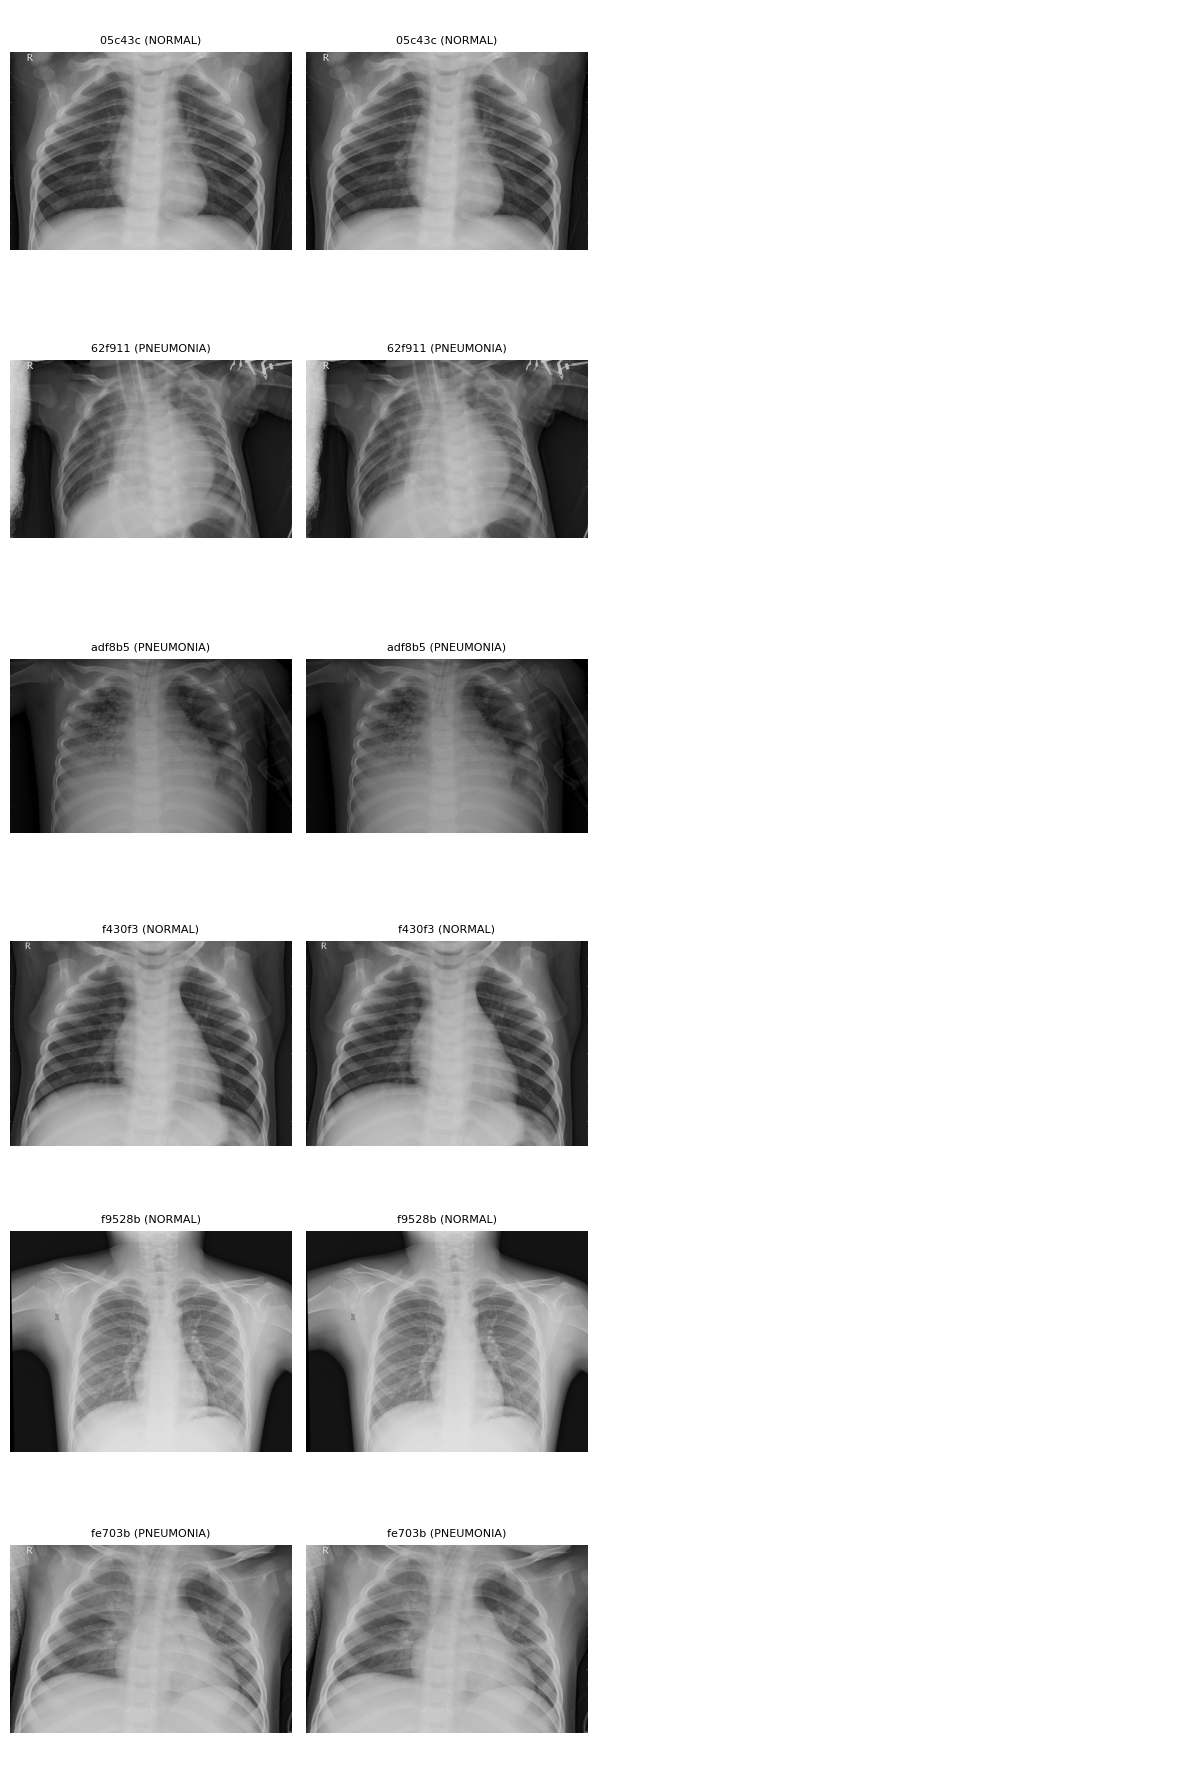

In [21]:
plot_duplicates_by_hash(test_duplicates)

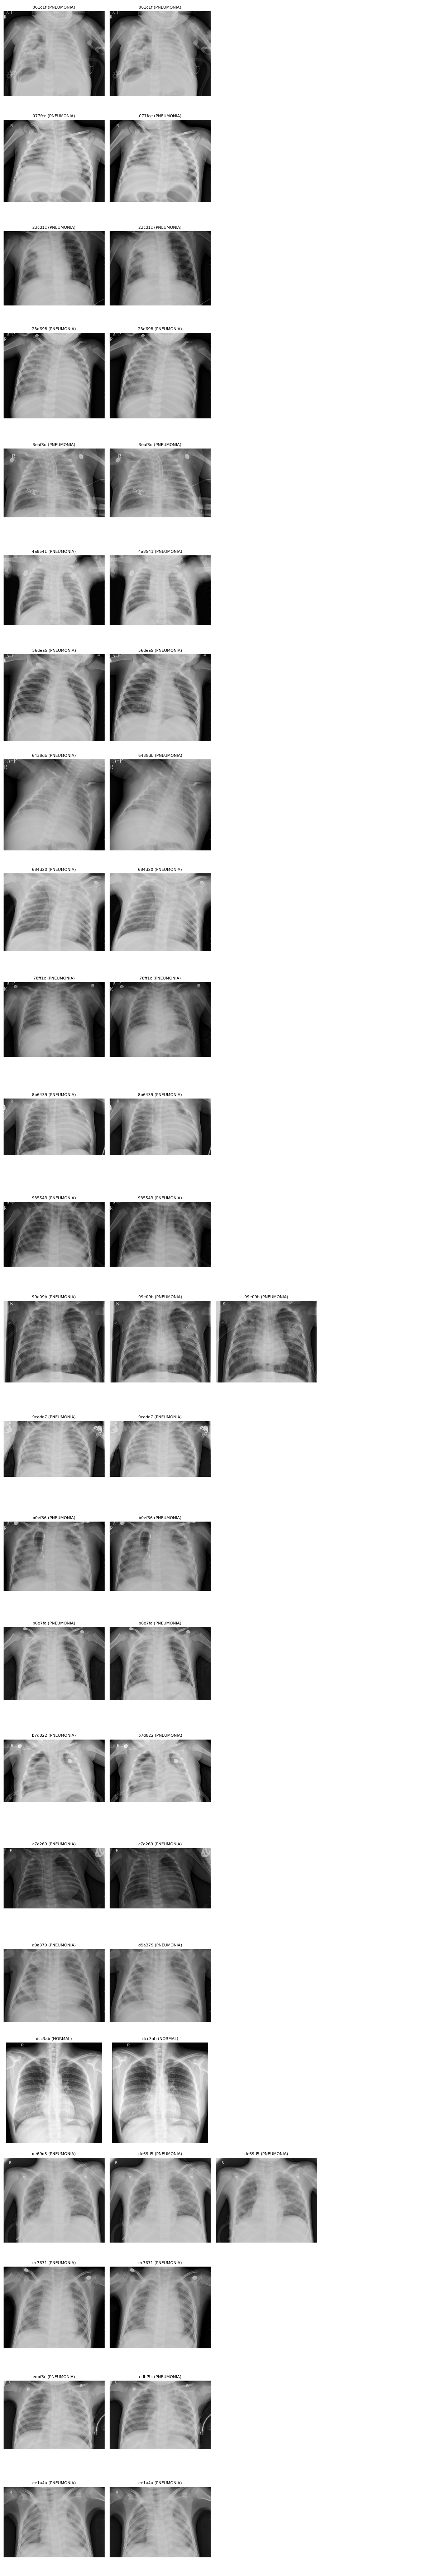

In [23]:
# Run the function on the duplicates dataset
plot_duplicates_by_hash(train_duplicates)

In [25]:
# Add a hash column to detect duplicates
train_df['hash'] = train_df['image_path'].apply(get_image_hash)
test_df['hash'] = test_df['image_path'].apply(get_image_hash)
val_df['hash'] = val_df['image_path'].apply(get_image_hash)

# Drop duplicate hashes but keep the first occurrence
train_df_cleaned = train_df.drop_duplicates(subset=['hash'], keep='first')
test_df_cleaned = test_df.drop_duplicates(subset=['hash'], keep='first')
val_df_cleaned = val_df

# Save cleaned datasets
train_df_cleaned.to_csv("train_data_cleaned.csv", index=False)
test_df_cleaned.to_csv("test_data_cleaned.csv", index=False)
val_df_cleaned.to_csv("val_data_cleaned.csv", index=False)

# Print summary
print(f"Original training set size: {len(train_df)}, After removing duplicates: {len(train_df_cleaned)}")
print(f"Original test set size: {len(test_df)}, After removing duplicates: {len(test_df_cleaned)}")

Original training set size: 5216, After removing duplicates: 5190
Original test set size: 624, After removing duplicates: 618


In [27]:
# Combine into a single dataset
full_dataset_df = pd.concat([train_df_cleaned, val_df, test_df_cleaned], ignore_index=True)

# Save this merged dataset for further analysis
full_dataset_df.to_csv("full_dataset.csv", index=False)

print(f"Total dataset size after merging: {len(full_dataset_df)}")

Total dataset size after merging: 5824


In [29]:
# Check for duplicate hashes across the full dataset
duplicates = full_dataset_df[full_dataset_df.duplicated(subset=['hash'], keep=False)]

print(f"Total duplicate images in full dataset: {len(duplicates)}")

Total duplicate images in full dataset: 0


### 2.3: Image Quality Check

In [31]:
# Function to check corrupt images
def check_corrupt_images(df, dataset_name):
    print(f"Checking for corrupt images in {dataset_name}...")
    missing_files = 0
    unreadable_files = 0
    
    for img_path in df['image_path']:
        if not os.path.exists(img_path):
            missing_files += 1
        else:
            img = cv2.imread(img_path)
            if img is None:
                unreadable_files += 1

    print(f"Missing images in {dataset_name}: {missing_files}")
    print(f"Unreadable/corrupt images in {dataset_name}: {unreadable_files}")
    print("-" * 40)

In [33]:
check_corrupt_images(train_df_cleaned, "Training Set")
check_corrupt_images(test_df_cleaned, "Test Set")
check_corrupt_images(val_df, "Validation Set")

Checking for corrupt images in Training Set...
Missing images in Training Set: 0
Unreadable/corrupt images in Training Set: 0
----------------------------------------
Checking for corrupt images in Test Set...
Missing images in Test Set: 0
Unreadable/corrupt images in Test Set: 0
----------------------------------------
Checking for corrupt images in Validation Set...
Missing images in Validation Set: 0
Unreadable/corrupt images in Validation Set: 0
----------------------------------------


### 2.4: Label/Response Variable Imbalance

In [35]:
# Function to check imbalance
def check_imbalance(df, dataset_name):
    class_counts = df['label'].value_counts(normalize=True) * 100  # Get percentages
    print(f"Class percentage distribution in {dataset_name}:")
    print(class_counts.round(2).astype(str) + "%")
    print("-" * 40)

def viral_bacterial_imbalance(df):
    # Total pneumonia cases
    total_pneumonia = df[df['label'] == 'PNEUMONIA'].shape[0]
    
    # Count viral and bacterial cases
    viral_count = df[df['image_path'].str.contains('virus', case=False)]['label'].count()
    bacterial_count = df[df['image_path'].str.contains('bacteria', case=False)]['label'].count()
    
    # Calculate percentages
    viral_percentage = (viral_count / total_pneumonia) * 100 if total_pneumonia > 0 else 0
    bacterial_percentage = (bacterial_count / total_pneumonia) * 100 if total_pneumonia > 0 else 0

    # Print results
    print(f" - Viral Pneumonia: {viral_count} ({viral_percentage:.2f}%)")
    print(f" - Bacterial Pneumonia: {bacterial_count} ({bacterial_percentage:.2f}%)")

In [37]:
check_imbalance(train_df_cleaned, "Training Set")
check_imbalance(val_df, "Validation Set")
check_imbalance(test_df_cleaned, "Test Set")

Class percentage distribution in Training Set:
label
PNEUMONIA    74.18%
NORMAL       25.82%
Name: proportion, dtype: object
----------------------------------------
Class percentage distribution in Validation Set:
label
NORMAL       50.0%
PNEUMONIA    50.0%
Name: proportion, dtype: object
----------------------------------------
Class percentage distribution in Test Set:
label
PNEUMONIA    62.62%
NORMAL       37.38%
Name: proportion, dtype: object
----------------------------------------


As we can see there is some imbalance in the classes. The dataset that causes the most concern is the training dataset, with a little less than 30% of the data being from the `NORMAL` class. This means that we could be training our model to biased towards predicting pneumonia rather than no pneumonia. In the case of healthcare, we would rather have false positives than false negatives, so we will not worry about addressing this imbalance (unless needed later for efficacy). We are dully not as concerned due to the fact that we have a large number of images in the training set in general.

In [39]:
# Run function on datasets
print("Training Set:")
viral_bacterial_imbalance(train_df_cleaned)

print("\nTest Set:")
viral_bacterial_imbalance(test_df_cleaned)

print("\nValidation Set:")
viral_bacterial_imbalance(val_df)

Training Set:
 - Viral Pneumonia: 1338 (34.75%)
 - Bacterial Pneumonia: 2512 (65.25%)

Test Set:
 - Viral Pneumonia: 147 (37.98%)
 - Bacterial Pneumonia: 240 (62.02%)

Validation Set:
 - Viral Pneumonia: 0 (0.00%)
 - Bacterial Pneumonia: 8 (100.00%)


In regard to the subtypes of pneumonia, it looks like most cases are bacterial. If our goal is to identify normal, bacterial pneumonia, and viral pneumonia rather than just normal versus pneumonia this might cause a concern. For now, we will focus on simply diagnosing pneumonia via the x-ray images, but I do think a hierarchical model might be the best approach.

### 2.5: Image format and conversion

In [41]:
def check_image_channels_pil(df, num_samples=10):
    channel_counts = {"L": 0, "RGB": 0, "RGBA": 0, "Other": 0}

    for img_path in df['image_path'].sample(num_samples, random_state=42):
        try:
            img = Image.open(img_path)  # Load image without conversion
            #print(f"Image Path: {img_path} | Mode: {img.mode}")  # Print actual storage mode

            # Count the image mode
            if img.mode in channel_counts:
                channel_counts[img.mode] += 1
            else:
                channel_counts["Other"] += 1  # Catch unexpected formats

        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    # Print summary
    print("\nImage Mode Summary:")
    for mode, count in channel_counts.items():
        print(f"{mode}: {count}")

def convert_rgb_to_grayscale(df):
    for img_path in df['image_path']:
        try:
            img = Image.open(img_path)  # Open image
            
            if img.mode == "RGB":  # Only convert if it's stored as RGB
                img = img.convert("L")  # Convert to grayscale
                img.save(img_path)  # Overwrite the existing file
                # print(f"Converted to grayscale: {img_path}")

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

Now, we check to see how many images are in each format. Our output should show that we have all grayscale images because the conversion has already been completed. However, before cleaning there were 283 images that were in RGB while the remaining 5,541 were in true grayscale.

In [43]:
# Run function to check actual image storage formats
check_image_channels_pil(full_dataset_df, num_samples=full_dataset_df.shape[0])

# Run function to convert only RGB images
# convert_rgb_to_grayscale(full_dataset_df)


Image Mode Summary:
L: 5824
RGB: 0
RGBA: 0
Other: 0


## Step 3: Exploratory Data Analysis (EDA)

---

### 3.1: Univariate Analysis

Before digging into the specifics of the label distribution and counts, let's take a look at the images and think through some of the key components to explore the in the univariate analysis.

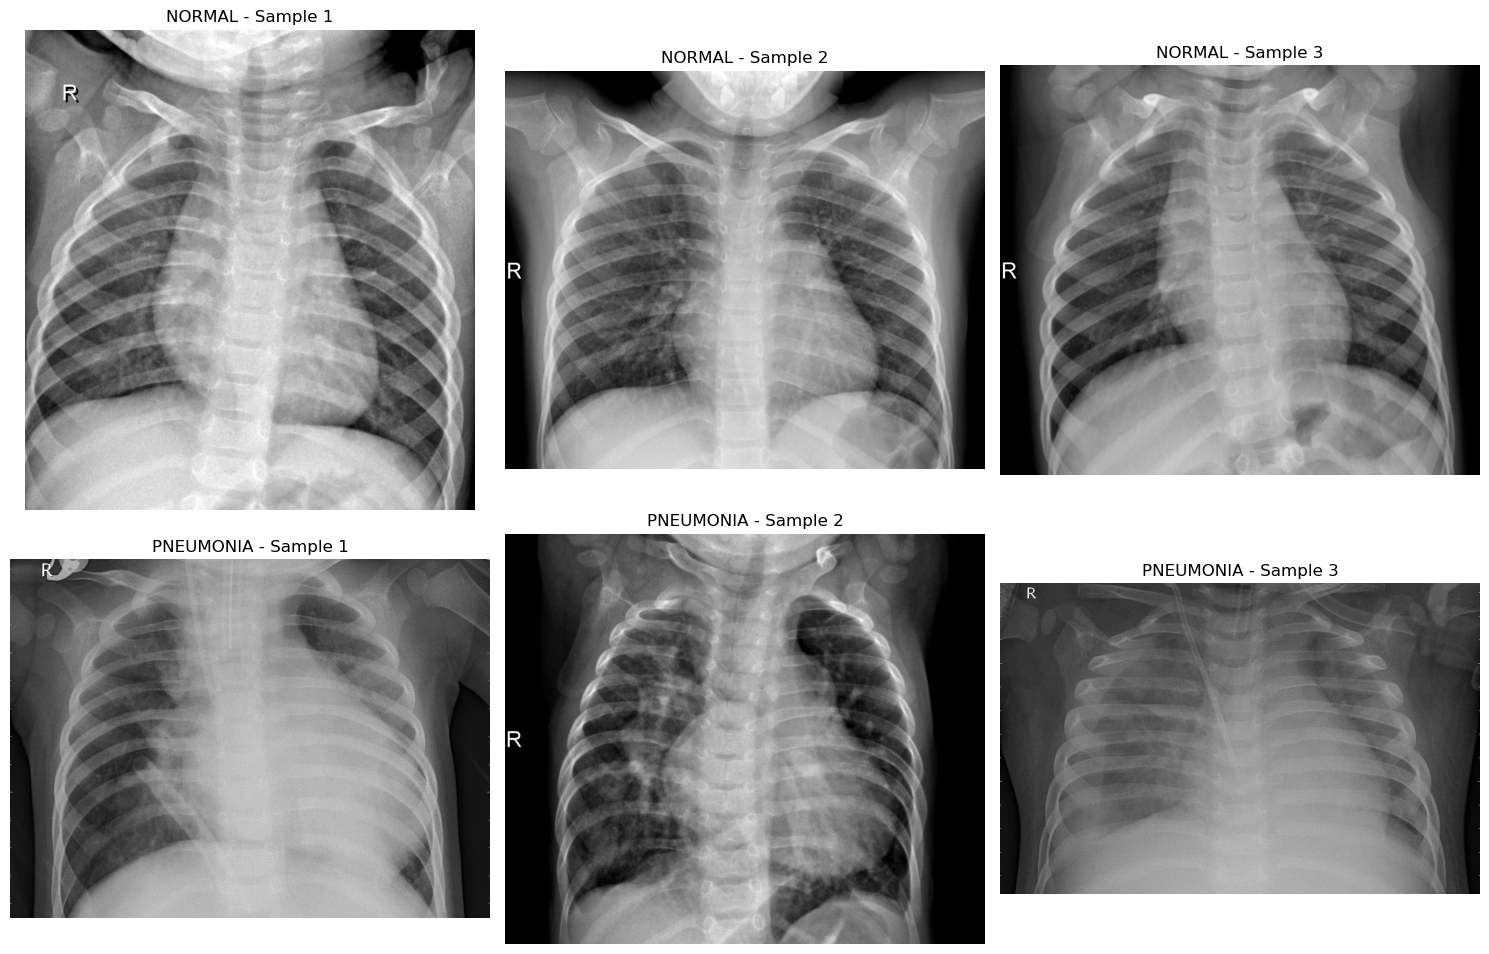

In [47]:
# Function to display sample images from each class
def show_sample_images(df, num_samples=3):
    fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 10))
    classes = ['NORMAL', 'PNEUMONIA']

    for i, category in enumerate(classes):
        # Get image paths for this category
        category_images = df[df['label'] == category]['image_path'].sample(num_samples, random_state=22197).tolist()
        
        for j, img_path in enumerate(category_images):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].set_title(f"{category} - Sample {j+1}")
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.savefig('images/sample_images.png')
    plt.show()

# Show sample images
show_sample_images(full_dataset_df)

Given that our images are in grayscale, we are limited to only one aspect of each pixel: it's value on the grayscale. On the grayscale 0 indicates black and 255 indicates white (i.e., as the value increase the brightness inceases). So, this pixel intensity is one variable we can take a look at other than the response variable (label of the image). We can also examine this pixel intensity in a few different ways. First, we can look at the average pixel intensity (brightness) of an image. Second, we can take a look at the standard  deviation of the pixel intensity (contrast) of an image. 

#### 3.1.1: Response variable (label)

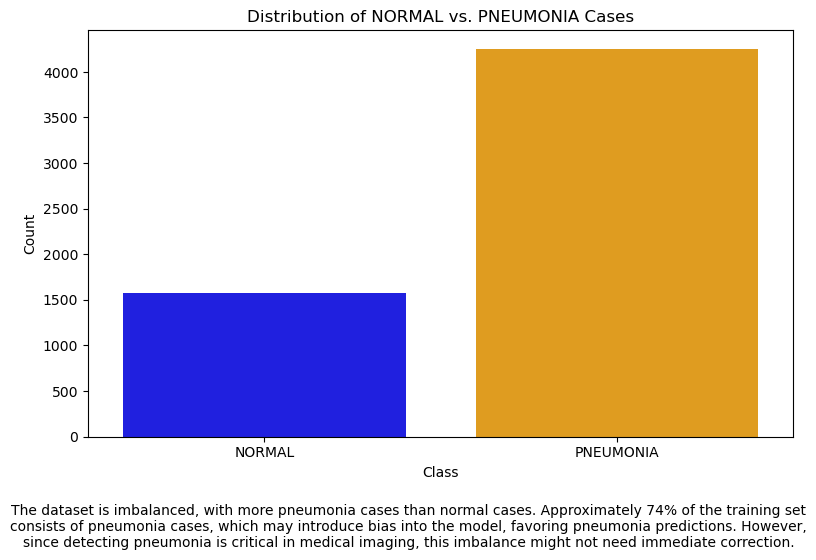

In [49]:
def plot_class_distribution(df):
    plt.figure(figsize=(8, 5))
    
    # Countplot of Normal vs Pneumonia
    sns.countplot(x=df['label'], hue=df['label'], palette=["blue", "orange"])
    
    plt.title("Distribution of NORMAL vs. PNEUMONIA Cases")
    plt.xlabel("Class")
    plt.ylabel("Count")
    # Add caption inside the plot
    plt.figtext(0.5, -0.1, "The dataset is imbalanced, with more pneumonia cases than normal cases. "
                            "Approximately 74% of the training set consists of pneumonia cases, which may introduce bias into the model, favoring pneumonia predictions."
                            " However, since detecting pneumonia is critical in medical imaging, this imbalance might not need immediate correction.", 
            wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('images/class_distribution.png')
    plt.show()

# Run function
plot_class_distribution(full_dataset_df)

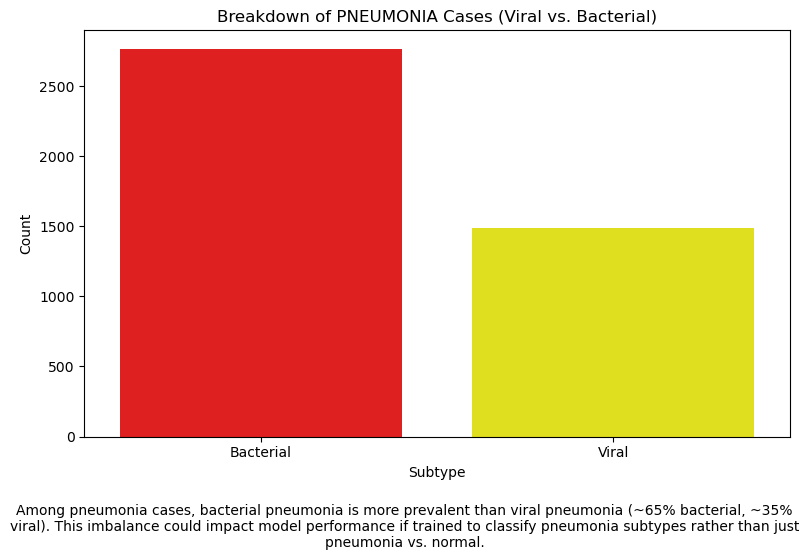

In [51]:
def plot_pneumonia_subtypes(df):
    plt.figure(figsize=(8, 5))
    
    # Extract pneumonia cases
    pneumonia_cases = df.copy()[df['label'] == 'PNEUMONIA']
    
    # Count occurrences of 'virus' and 'bacteria' in file names
    pneumonia_cases["subtype"] = pneumonia_cases["image_path"].apply(
        lambda x: "Viral" if "virus" in x.lower() else "Bacterial"
    )
    
    # Countplot for Viral vs. Bacterial Pneumonia
    sns.countplot(x=pneumonia_cases["subtype"], hue=pneumonia_cases["subtype"], palette=["red", "yellow"])
    
    plt.title("Breakdown of PNEUMONIA Cases (Viral vs. Bacterial)")
    plt.xlabel("Subtype")
    plt.ylabel("Count")
    # Add caption inside the plot
    plt.figtext(0.5, -0.1, "Among pneumonia cases, bacterial pneumonia is more prevalent than viral pneumonia (~65% bacterial, ~35% viral)."
                            " This imbalance could impact model performance if trained to classify pneumonia subtypes rather than just pneumonia vs. normal.", 
            wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('images/pneumonia_distribution.png')
    plt.show()

# Run function
plot_pneumonia_subtypes(full_dataset_df)

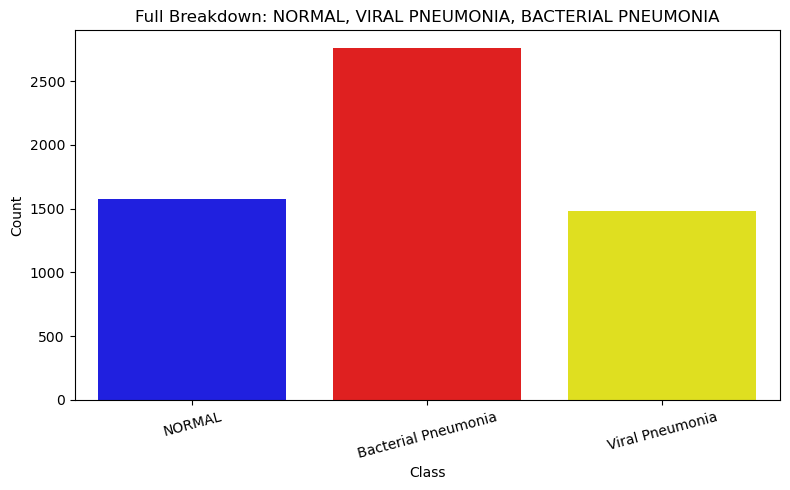

In [53]:
def plot_full_label_distribution(df):
    plt.figure(figsize=(8, 5))

    # Create a new column to classify all three categories
    df["disease_type"] = df["label"]
    df.loc[df["label"] == "PNEUMONIA", "disease_type"] = df["image_path"].apply(
        lambda x: "Viral Pneumonia" if "virus" in x.lower() else "Bacterial Pneumonia"
    )
    
    # Countplot for all three categories
    sns.countplot(x=df["disease_type"], hue = df["disease_type"], palette=["blue", "red", "yellow"])
    
    plt.title("Full Breakdown: NORMAL, VIRAL PNEUMONIA, BACTERIAL PNEUMONIA")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/full_class_distribution.png')
    plt.show()

# Run function
plot_full_label_distribution(full_dataset_df)

Given that raw pixel values alone may not provide the most meaningful patterns, we now extract key image features such as brightness, contrast, and texture.

#### 3.1.2: Brightness and Contrast

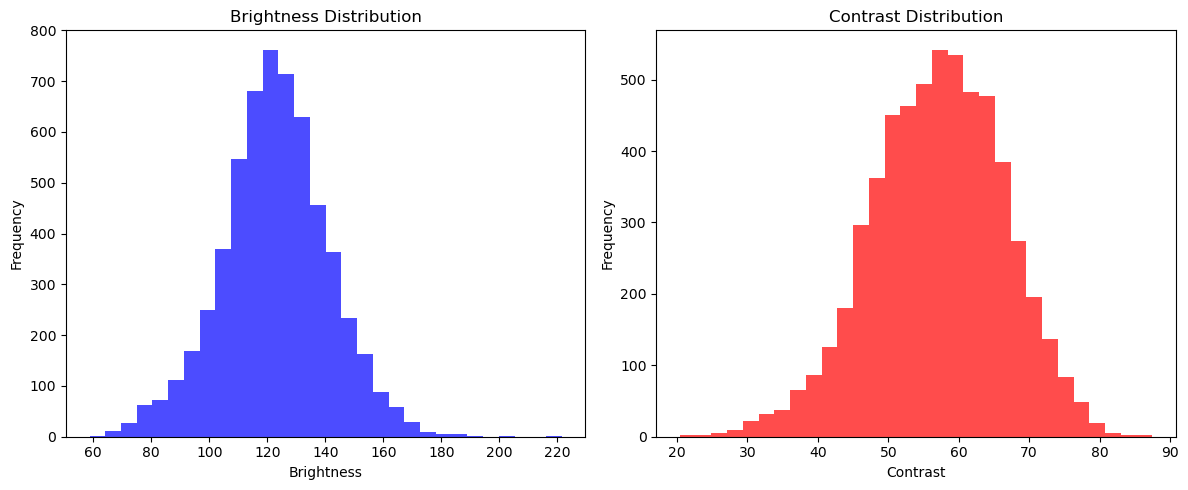

In [55]:
# Function to compute brightness & contrast
def analyze_brightness_contrast(df):
    brightness_values = []
    contrast_values = []

    for img_path in df['image_path']:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness = np.mean(img)  # Average pixel intensity
            contrast = np.std(img)  # Standard deviation of pixel intensities
            brightness_values.append(brightness)
            contrast_values.append(contrast)

    return brightness_values, contrast_values

# Analyze training set brightness & contrast
brightness, contrast = analyze_brightness_contrast(full_dataset_df)

# Plot histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(brightness, bins=30, color='blue', alpha=0.7)
ax[0].set_title("Brightness Distribution")
ax[0].set_xlabel("Brightness")
ax[0].set_ylabel("Frequency")

ax[1].hist(contrast, bins=30, color='red', alpha=0.7)
ax[1].set_title("Contrast Distribution")
ax[1].set_xlabel("Contrast")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig('images/brightness_and_contrast.png')
plt.show()

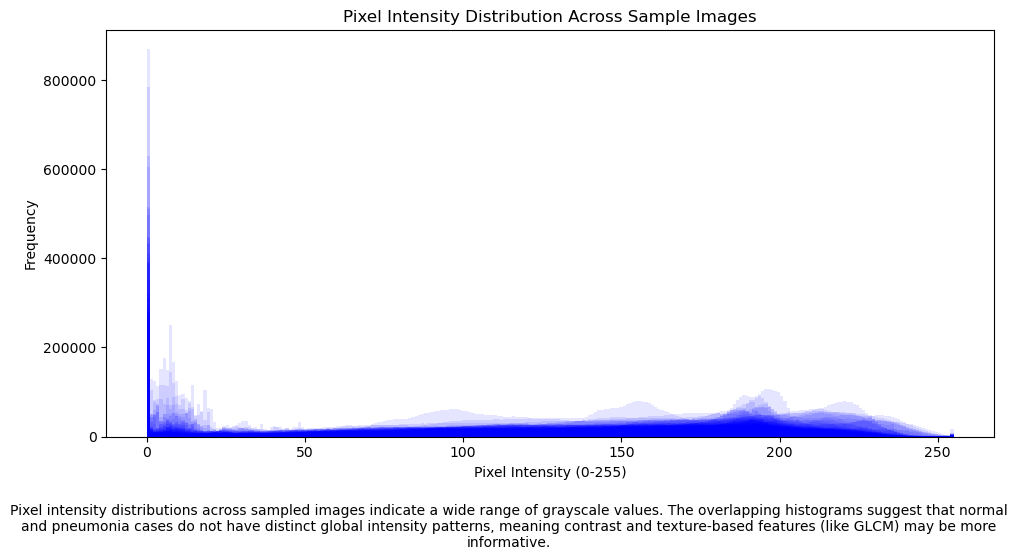

In [57]:
def plot_pixel_intensity_distribution(df, num_samples=100):
    plt.figure(figsize=(10, 5))

    for img_path in df['image_path'].sample(num_samples, random_state=42):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            plt.hist(img.ravel(), bins=256, alpha=0.1, color='blue')

    plt.title("Pixel Intensity Distribution Across Sample Images")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")
    # Add caption inside the plot
    plt.figtext(0.5, -0.1, "Pixel intensity distributions across sampled images indicate a wide range of grayscale values. "
                            "The overlapping histograms suggest that normal and pneumonia cases do not have distinct global intensity patterns, meaning contrast and texture-based features (like GLCM) may be more informative.", 
            wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('images/pixel_intensity_image_by_image.png')
    plt.show()

# Run on full dataset
plot_pixel_intensity_distribution(full_dataset_df, num_samples=math.ceil(full_dataset_df.shape[0]*0.10))

#### 3.1.3: Texture-Based Analysis using Gray-Level Co-Occurrence Matrix (GLCM)

In this bootcamp, much of the data preparation and analysis has focused on tabular data. For this project, I wanted to step out of my comfort zone and adapt what I have learned to new data types and analytical methods. Specifically, I explored how these techniques can be applied to images and tabular pixel data.

For exploratory data analysis (EDA), I sought to extract meaningful features from images that could be used in univariate, bivariate, and multivariate analyses. One of the first techniques I researched was the Gray-Level Co-Occurrence Matrix (GLCM), which was initially introduced in a 1973 paper by Robert M. Haralick, K. Shanmugam, and Its’Hak Dinstein.

GLCM is a method for quantifying texture in images by measuring the frequency of pixel intensity co-occurrences within a defined spatial relationship. For example, we can examine how often each pixel intensity appears next to another pixel intensity (e.g., first neighboring pixel to the right, row by row). By counting these occurrences, we construct a co-occurrence matrix, from which we can derive key texture features:

**GLCM Contrast**

GLCM Contrast is different from standard image contrast (i.e., standard deviation of pixel intensity values). Instead of measuring global intensity spread, GLCM Contrast measures local intensity variation across an image, using the co-occurrence probabilities of neighboring pixel pairs.
- Higher values → Sharp textures with large variations.
- Lower values → Softer edges with smaller variations.
- Use case: Helps identify regions of high variation, such as pneumonia-related lung opacity.

**GLCM Correlation**

GLCM Correlation is not the same as Pearson correlation, though it is conceptually similar in measuring relationships. Instead of measuring linear dependence between two variables, it evaluates how pixel intensities change together in spatial proximity.
- Higher values → Neighboring pixels have a strong intensity relationship (smooth texture).
- Lower values → Neighboring pixels vary more randomly (rougher texture).
- Use case: Helps identify structured vs. chaotic patterns, useful in detecting lung abnormalities.

**GLCM Energy**

GLCM Energy measures the uniformity of textures by summing the squared probabilities of co-occurring pixel intensities. Because it squares the probabilities, frequently occurring intensity pairs contribute disproportionately to the total.
- Value range: 0 to 1.
- Higher values → More uniform texture (e.g., healthy lungs, man-made objects in X-rays).
- Lower values → Erratic, irregular textures (e.g., infections or unexpected anomalies).
- Use case: Helps distinguish smooth, normal lung structures from irregular textures caused by disease.

**GLCM Homogeneity**

GLCM Homogeneity quantifies how similar neighboring pixel intensities are. It does so by penalizing large intensity differences, ensuring that neighboring pixel pairs with similar values contribute more to the total score.
￼
- Higher values → Smooth textures with minimal variation.
- Lower values → Rough, jagged textures with significant local differences.
- Use case: Helps detect lung texture smoothness, distinguishing healthy lungs from pneumonia-affected areas.

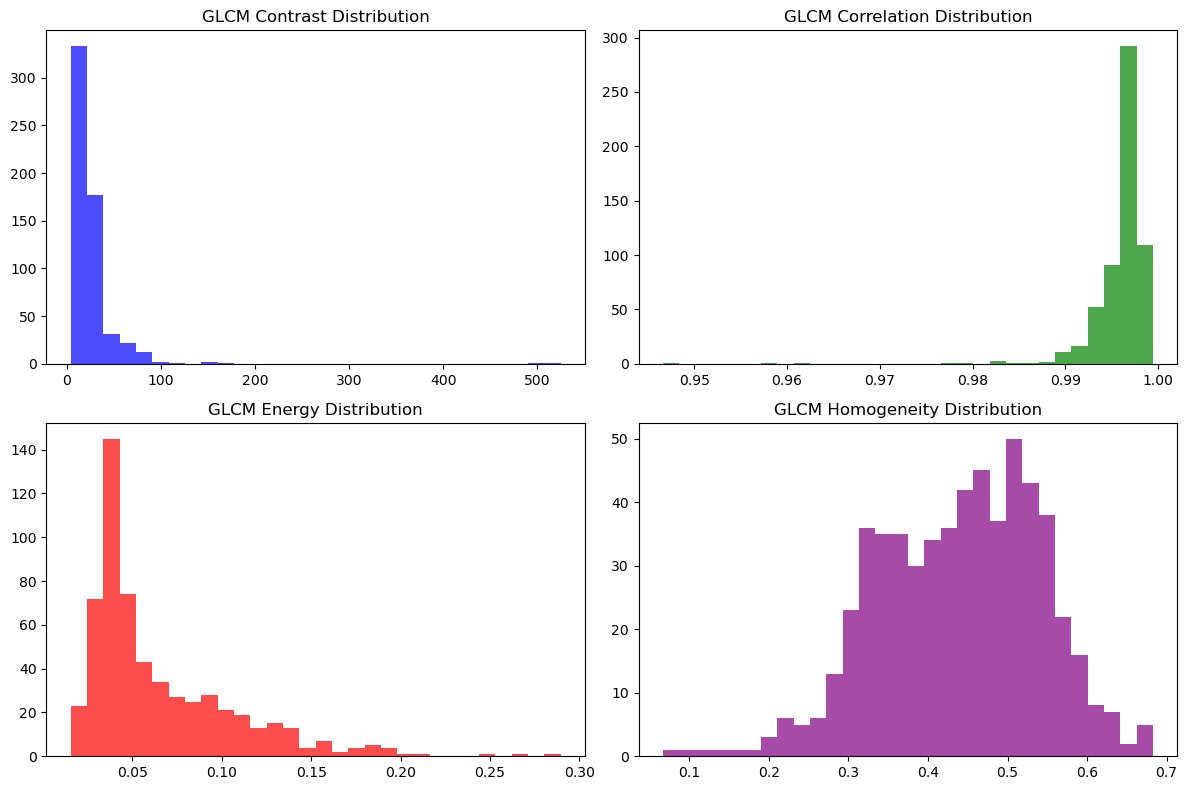

In [59]:
# Function to compute GLCM features
def compute_glcm_features(df, num_samples=300):
    contrast_vals, correlation_vals, energy_vals, homogeneity_vals = [], [], [], []

    for img_path in df['image_path'].sample(num_samples, random_state=42):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]
            energy = graycoprops(glcm, 'energy')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

            contrast_vals.append(contrast)
            correlation_vals.append(correlation)
            energy_vals.append(energy)
            homogeneity_vals.append(homogeneity)

    return contrast_vals, correlation_vals, energy_vals, homogeneity_vals

# Compute GLCM features
contrast_vals, correlation_vals, energy_vals, homogeneity_vals = compute_glcm_features(full_dataset_df,
                                                                                       num_samples=math.ceil(full_dataset_df.shape[0]*0.10))

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(contrast_vals, bins=30, color='blue', alpha=0.7)
axes[0, 0].set_title("GLCM Contrast Distribution")

axes[0, 1].hist(correlation_vals, bins=30, color='green', alpha=0.7)
axes[0, 1].set_title("GLCM Correlation Distribution")

axes[1, 0].hist(energy_vals, bins=30, color='red', alpha=0.7)
axes[1, 0].set_title("GLCM Energy Distribution")

axes[1, 1].hist(homogeneity_vals, bins=30, color='purple', alpha=0.7)
axes[1, 1].set_title("GLCM Homogeneity Distribution")

plt.tight_layout()
plt.savefig('images/GLCM_values.png')
plt.show()

**GLCM Contrast**

Here we can see that most of the images have very little GLCM contrast, but the distribution is highly right-skewed. We will have to explore this later, but my initial thoughts are that some extreme pneumonia cases or X-rays with artifacts (man-made objects) might show extreme local contrast.

**GLCM Correlation**

The GLCM correlation distribution is highly left-skewed but still concentrated in the higher values of GLCM correlation. Since higher correlation indicates a smoother, more consistent texture, this is likely detecting the organized and structured nature of lung tissue. We would only expect to see lower correlation in lungs with uneven infection or X-rays with poor image quality. In our case, it looks like our X-rays are high quality, and the variation between healthy and unhealthy lungs in GLCM correlation would likely be minimal, if it exists.

**GLCM Energy**

For GLCM energy, we must remember that lower energy indicates more complex structures, while higher energy suggests smoother, more uniform textures. Most of our images have lower energy, and the distribution is right-skewed, extending toward 0.30. Here, I think most images will have lower energy because chest/lung X-rays naturally lack uniformity. The images in the right tail of the distribution might have higher energy due to man-made artifacts appearing in the X-ray.

**GLCM Homogeneity**
This is our most normally distributed feature, with a small left tail and values concentrating between 0.3 and 0.6. This range suggests that our X-rays contain a mixture of both smooth and rough textures. We will need to examine this further using the class labels to determine whether there is a difference in GLCM homogeneity between healthy and infected lungs.

**Below is an anlysis to interpret if we can reduce the number of gray levels while maintaining fidelity in our GLCM metrics**

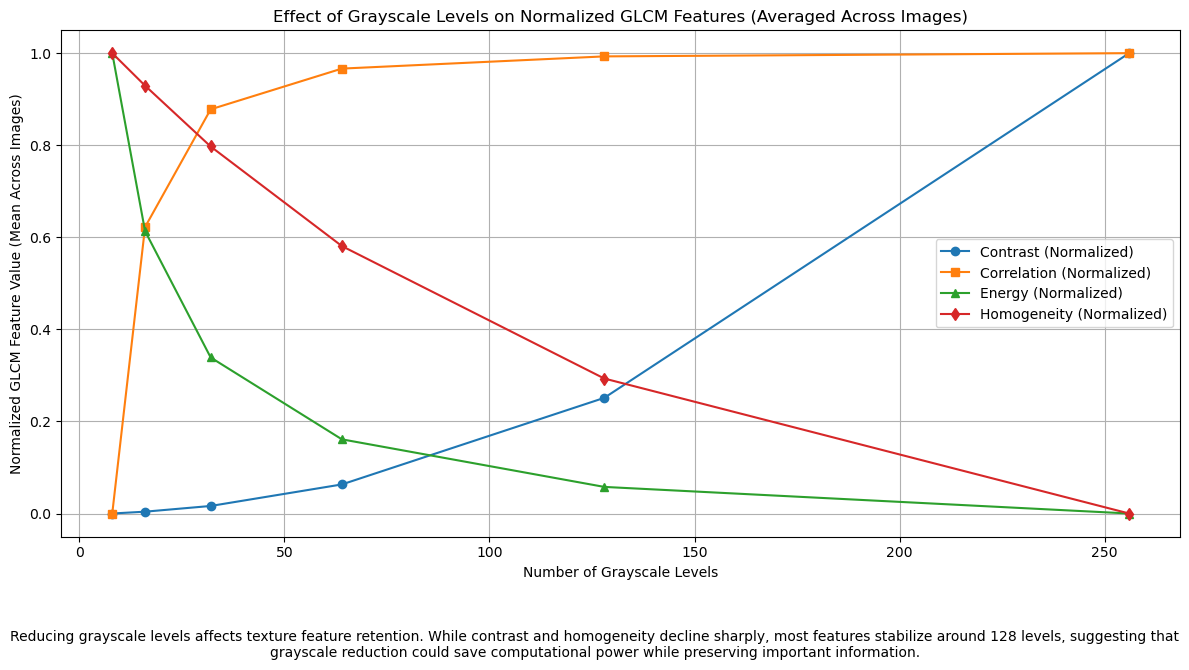

In [61]:
def compute_glcm_features(img_paths, num_levels_list=[8, 16, 32, 64, 128, 256]):
    results = {level: [] for level in num_levels_list}  # Store lists to compute mean later

    for img_path in img_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Skip if image fails to load

        for num_levels in num_levels_list:
            # Rescale image to the specified number of levels
            img_rescaled = (img / 255 * (num_levels - 1)).astype('uint8')

            # Compute GLCM using multiple angles
            glcm = graycomatrix(img_rescaled, [1], [0, 45, 90, 135], symmetric=True, normed=True)

            # Compute mean across all angles
            contrast = np.mean(graycoprops(glcm, 'contrast'))
            correlation = np.mean(graycoprops(glcm, 'correlation'))
            energy = np.mean(graycoprops(glcm, 'energy'))
            homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))

            # Append to lists
            results[num_levels].append([contrast, correlation, energy, homogeneity])

    # Compute mean GLCM features across all images
    results_mean = {level: np.mean(results[level], axis=0) for level in num_levels_list}

    # Convert to numpy for normalization
    feature_array = np.array(list(results_mean.values()))  # Shape (num_levels, 4)

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    feature_array_scaled = scaler.fit_transform(feature_array)  

    # Convert back to dictionary format
    results_mean_scaled = {level: feature_array_scaled[i] for i, level in enumerate(num_levels_list)}

    return results_mean_scaled

# ✅ Sample multiple images (e.g., 50 images)
num_samples = math.ceil(full_dataset_df.shape[0]*0.10)
sampled_img_paths = full_dataset_df['image_path'].sample(num_samples, random_state=42).values

# Run analysis with normalization
glcm_results_scaled = compute_glcm_features(sampled_img_paths)

# Convert to numpy for easy plotting
levels = np.array(list(glcm_results_scaled.keys()))
features_scaled = np.array(list(glcm_results_scaled.values()))

# Plot the normalized GLCM features vs. grayscale levels
plt.figure(figsize=(12, 6))
plt.plot(levels, features_scaled[:, 0], label='Contrast (Normalized)', marker='o')
plt.plot(levels, features_scaled[:, 1], label='Correlation (Normalized)', marker='s')
plt.plot(levels, features_scaled[:, 2], label='Energy (Normalized)', marker='^')
plt.plot(levels, features_scaled[:, 3], label='Homogeneity (Normalized)', marker='d')

plt.xlabel("Number of Grayscale Levels")
plt.ylabel("Normalized GLCM Feature Value (Mean Across Images)")
plt.title("Effect of Grayscale Levels on Normalized GLCM Features (Averaged Across Images)")
plt.legend()
plt.grid()
# Add caption inside the plot
plt.figtext(0.5, -0.1, "Reducing grayscale levels affects texture feature retention." 
                        " While contrast and homogeneity decline sharply, most features" 
                        " stabilize around 128 levels, suggesting that grayscale reduction" 
                        " could save computational power while preserving important information.", 
            wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.savefig('images/grayscale_levels_analysis.png')
plt.show()

As we can see, it looks like most of the metrics stabilize around the 128 levels. This means, we could reduce our grayscale levels from 256 to 128 and might be able to keep a good a majority of the information.

For now, we will keep 256 levels, but might want to explore if 128 levels is enough to save computational power. We also might explore transformations to correct these distributions.

#### 3.1.4: Edge Strength of Images (Sobel Filter)

In addition to texture analysis using GLCM, I explored edge detection to extract meaningful features. One method I found in my research was the Sobel filter, a convolutional kernel designed to detect sharp intensity changes, which correspond to edges of structures in an image.

The Sobel filter applies two gradient-based kernels—one for the horizontal direction and one for the vertical direction—to compute intensity changes. By combining these, we calculate the edge magnitude at each pixel. Finally, we take the average edge magnitude across the entire image to compute Edge Strength.

- Higher edge strength → Sharper boundaries within the image.
- Lower edge strength → Softer edges and smoother textures.

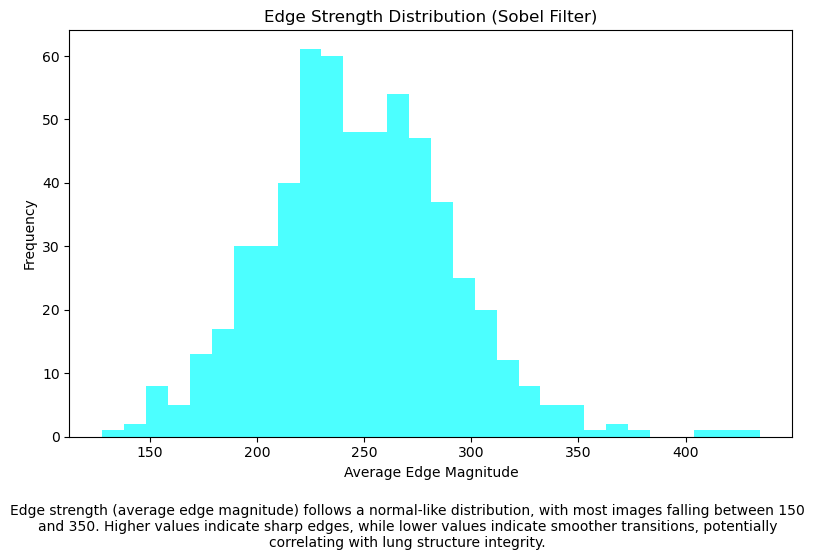

In [65]:
# Function to compute Sobel edges
def compute_edge_features(df, num_samples=math.ceil(full_dataset_df.shape[0]*0.10)):
    edge_strengths = []

    for img_path in df['image_path'].sample(num_samples, random_state=42):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
            edge_magnitude = np.sqrt(sobelx**2 + sobely**2)
            edge_strengths.append(np.mean(edge_magnitude))

    return edge_strengths

# Compute edge strengths
edge_strengths = compute_edge_features(full_dataset_df)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(edge_strengths, bins=30, color='cyan', alpha=0.7)
plt.title("Edge Strength Distribution (Sobel Filter)")
plt.xlabel("Average Edge Magnitude")
plt.ylabel("Frequency")
plt.figtext(0.5, -0.1, "Edge strength (average edge magnitude) follows a normal-like distribution,"
                        " with most images falling between 150 and 350. Higher values indicate sharp edges,"
                        " while lower values indicate smoother transitions, potentially correlating with lung"
                        " structure integrity.", 
            wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.savefig('images/sobel_filter_for_edge_detection.png')
plt.show()

In this analysis, I found that most of the images selected at random were had an edge strength (average edge magnitude) of 150 to 350. This is consistent with what we would expect since higher edge strength values would be more associated with extreme abrupt changes in intensity.

#### 3.1.5: Fourier Transform Energy

In addition to texture analysis using GLCM and edge detection using the Sobel filter, I explored frequency-based analysis to extract meaningful features from images. One approach I found in my research was the Fourier Transform, which decomposes an image into its frequency components, allowing us to analyze patterns that might not be visible in the spatial domain.

The Fourier Transform converts an image from the spatial domain to the frequency domain, where:

-	Low frequencies represent smooth, gradual changes in intensity.
-	High frequencies capture sharp transitions and fine details.

To compute Fourier Transform Energy, I applied the Fast Fourier Transform (FFT) to each image, then shifted the transformed data so that the low frequencies are centered. The magnitude spectrum was extracted, and the total energy was computed as the sum of squared magnitudes.

-	Higher Fourier Energy → The image contains more high-frequency components, meaning sharper transitions and more fine details.
-	Lower Fourier Energy → The image is dominated by low-frequency components, meaning it has smoother, more uniform textures.

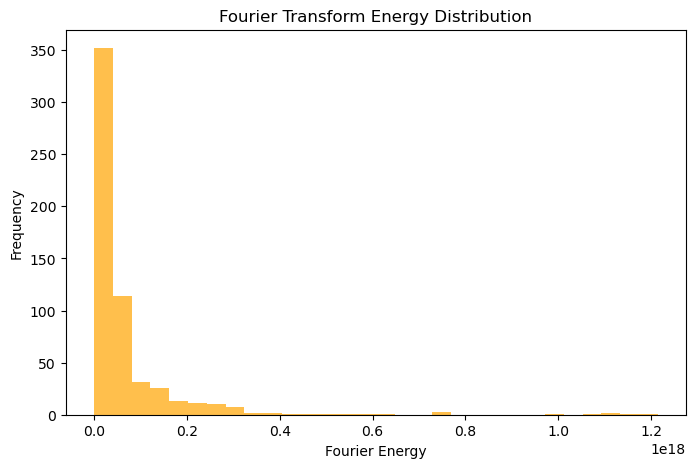

In [67]:
# Function to compute Fourier Transform Energy
def compute_fourier_energy(df, num_samples=300):
    fourier_energies = []

    for img_path in df['image_path'].sample(num_samples, random_state=42):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            f_transform = np.fft.fft2(img)
            f_transform_shift = np.fft.fftshift(f_transform)
            magnitude_spectrum = np.abs(f_transform_shift)
            energy = np.sum(magnitude_spectrum**2)
            fourier_energies.append(energy)

    return fourier_energies

# Compute Fourier Transform Energy
fourier_energies = compute_fourier_energy(full_dataset_df, num_samples=math.ceil(full_dataset_df.shape[0]*0.10))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(fourier_energies, bins=30, color='orange', alpha=0.7)
plt.title("Fourier Transform Energy Distribution")
plt.xlabel("Fourier Energy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('images/fourier_transform_energy.png')
plt.show()

In [69]:
np.min(fourier_energies)

84148664866560.02

In [71]:
np.max(fourier_energies)

1.2140514806912696e+18

Plotting the Fourier Transform Energy shows us that most of the values are lower on our scale, indicating smooth gradual changes. However, the range is extremely large and does not allow for a great understanding of the data. So, this would be a good candidate for a log based 10 transformation.

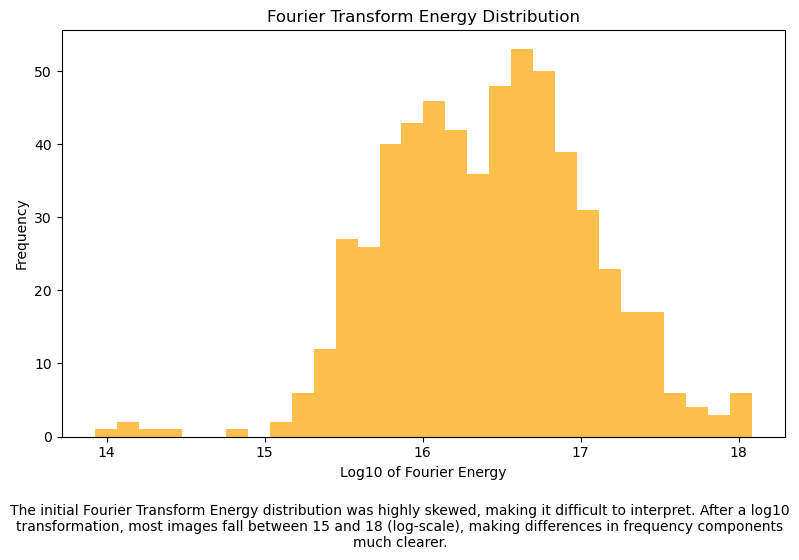

In [73]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(np.log10(fourier_energies), bins=30, color='orange', alpha=0.7)
plt.title("Fourier Transform Energy Distribution")
plt.xlabel("Log10 of Fourier Energy")
plt.ylabel("Frequency")
plt.figtext(0.5, -0.1, "The initial Fourier Transform Energy distribution was highly skewed,"
            " making it difficult to interpret. After a log10 transformation, most images"
            " fall between 15 and 18 (log-scale), making differences in frequency components much clearer.", 
            wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.savefig('images/log10_fourier_transform_energy.png')
plt.show()

This plot is much easier to interpret. As we can see, most of the images are within the range of 15 to 18 log10 of Fourier Transform Energy. There is a left tail indicating a bit of skewness. Further analysis in the bivariate analysis section should help to determine if there is a difference in the log10 of Fourier Energy between the healthy and infected lungs.

#### 3.1.6: Image Blurriness (Laplacian Variance)

The last unique feature I wanted to explore was the bluriness of the image. I found the one way to do this was using the Laplacian variance.

The Laplacian operator is a second-order derivative filter that detects regions of rapid intensity change—essentially highlighting edges and textures. Since blurry images tend to have fewer sharp edges, we can quantify blurriness by computing the variance of the Laplacian-transformed image. The higher the variance, the more high-frequency details the image contains.

To compute Laplacian Variance, I applied the Laplacian operator to each image and then calculated the variance of the resulting edge map:
	•	Higher Laplacian Variance → More edges, sharper details, and a well-defined image.
	•	Lower Laplacian Variance → Fewer edges, meaning the image is blurry or out of focus.

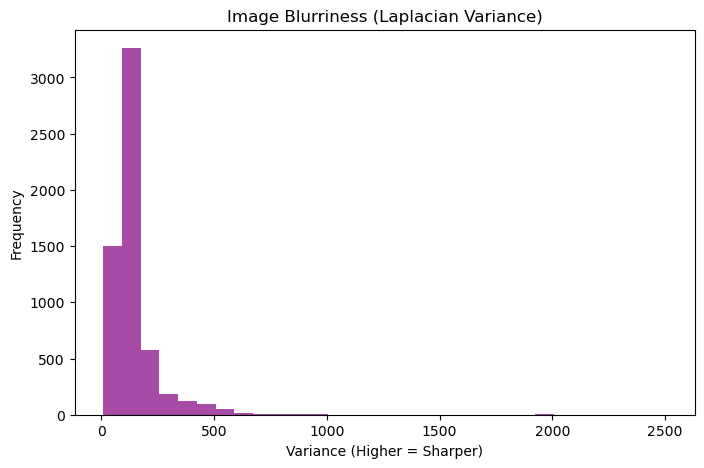

In [75]:
def analyze_image_blurriness(df, num_samples=200):
    blur_values = []

    for img_path in df['image_path'].sample(num_samples, random_state=42):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            variance = cv2.Laplacian(img, cv2.CV_64F).var()
            blur_values.append(variance)

    # Plot distribution
    plt.figure(figsize=(8, 5))
    plt.hist(blur_values, bins=30, color='purple', alpha=0.7)
    plt.title("Image Blurriness (Laplacian Variance)")
    plt.xlabel("Variance (Higher = Sharper)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig('images/laplacian_variance_for_image_blur.png')
    plt.show()

# Run on full dataset
analyze_image_blurriness(full_dataset_df, num_samples=full_dataset_df.shape[0])

As we can see most of the images have lower variance, meaning that the images are a bit blurry. We do have an extreme right tail. This feature might benefit from a log base-10 or square root transformation.

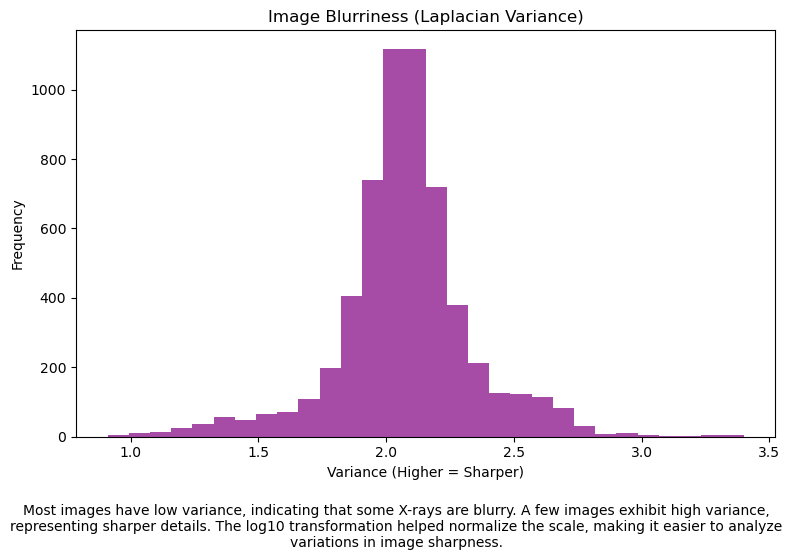

In [77]:
def analyze_image_log_blurriness(df, num_samples=200):
    blur_values = []

    for img_path in df['image_path'].sample(num_samples, random_state=42):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            variance = cv2.Laplacian(img, cv2.CV_64F).var()
            blur_values.append(variance)

    # Plot distribution
    plt.figure(figsize=(8, 5))
    plt.hist(np.log10(blur_values), bins=30, color='purple', alpha=0.7)
    plt.title("Image Blurriness (Laplacian Variance)")
    plt.xlabel("Variance (Higher = Sharper)")
    plt.ylabel("Frequency")
    plt.figtext(0.5, -0.1, "Most images have low variance, indicating that some X-rays are blurry."
                            " A few images exhibit high variance, representing sharper details."
                            " The log10 transformation helped normalize the scale, making it easier"
                            " to analyze variations in image sharpness.", 
            wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('images/log10_laplacian_variance_for_image_blur.png')
    plt.show()

# Run on full dataset
analyze_image_log_blurriness(full_dataset_df, num_samples=full_dataset_df.shape[0])

Looks like our log base-10 transformation worked very well.

#### 3.1.6: Image Size

The last image feature I explored was size (aspect ratio, width, and height). We will need to standardize all image sizes before setting up our model, so this exploration is more to get to know the data. Aspect ratio is defined as $\frac{\text{width}}{\text{height}}$. So, the higher the aspect ratio the wider and more landscape and image is and the smaller the more narrow and portrait. An aspect ratio of 1 is a square.

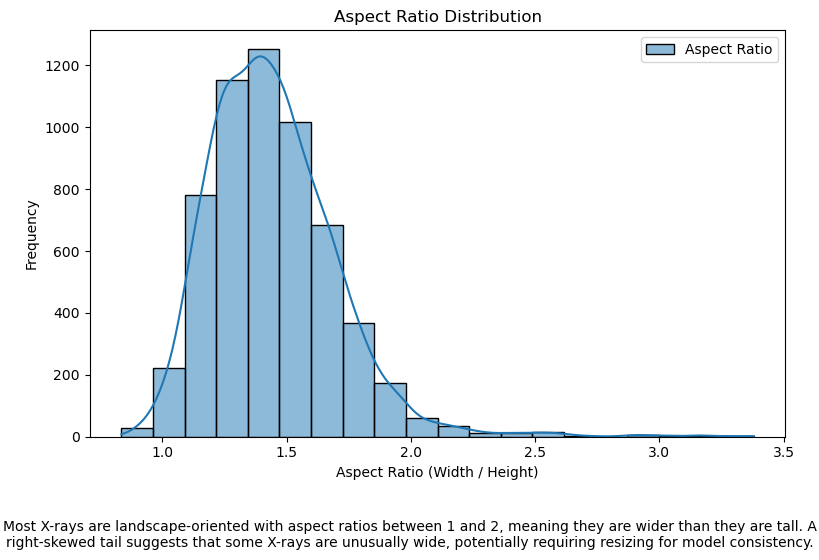

In [79]:
# Function to get image resolutions & aspect ratios
def analyze_image_sizes(df):
    sizes = []
    aspect_ratios = []

    for img_path in df['image_path']:  # Analyze 500 images
        img = cv2.imread(img_path)
        if img is not None:
            height, width = img.shape[:2]
            sizes.append((width, height))
            aspect_ratios.append(width / height)

    return sizes, aspect_ratios

# Compute sizes & aspect ratios
sizes, aspect_ratios = analyze_image_sizes(full_dataset_df)

# Convert to DataFrame
size_df = pd.DataFrame(sizes, columns=["Width", "Height"])
aspect_ratio_df = pd.DataFrame(aspect_ratios, columns=["Aspect Ratio"])

# Plot aspect ratio distribution
plt.figure(figsize=(8, 5))
sns.histplot(aspect_ratio_df, bins=20, kde=True)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.figtext(0.5, -0.1, "Most X-rays are landscape-oriented with aspect ratios between 1 and 2,"
                        " meaning they are wider than they are tall. A right-skewed tail suggests"
                        " that some X-rays are unusually wide, potentially requiring resizing for model consistency.", 
            wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.savefig('images/aspect_ratio.png')
plt.show()

Looks like most of the images are landscape with most being between 1 and 2. The distribution is rightly skewed meaning there are some very wide X-rays.

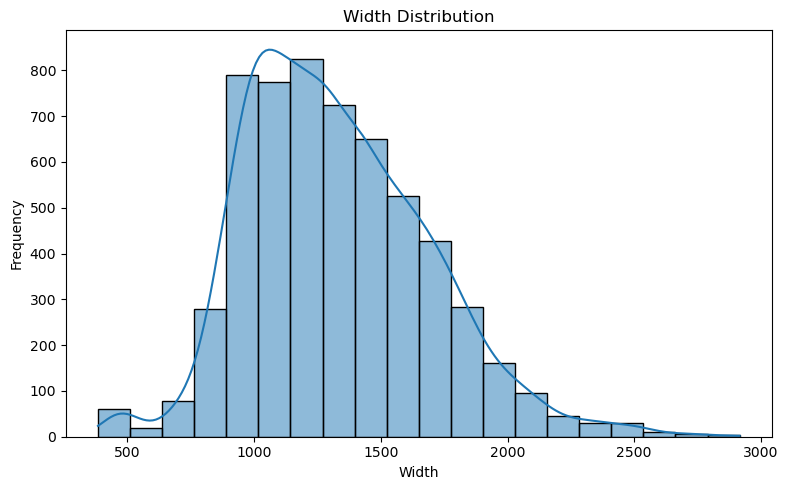

In [83]:
# Plot width distribution
plt.figure(figsize=(8, 5))
sns.histplot(size_df['Width'], bins=20, kde=True)
plt.title("Width Distribution")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('images/width.png')
plt.show()

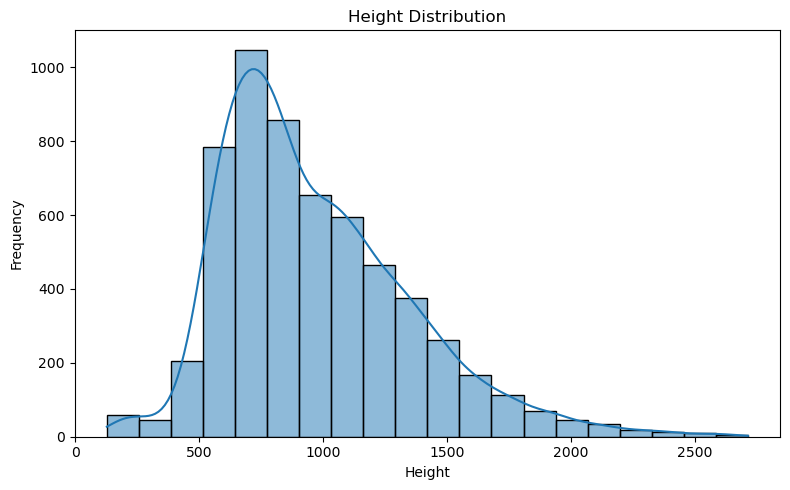

In [85]:
# Plot height distribution
plt.figure(figsize=(8, 5))
sns.histplot(size_df['Height'], bins=20, kde=True)
plt.title("Height Distribution")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('images/height.png')
plt.show()

### 3.2: Bivariate Analysis

#### 3.2.1: Brightness and Contrast

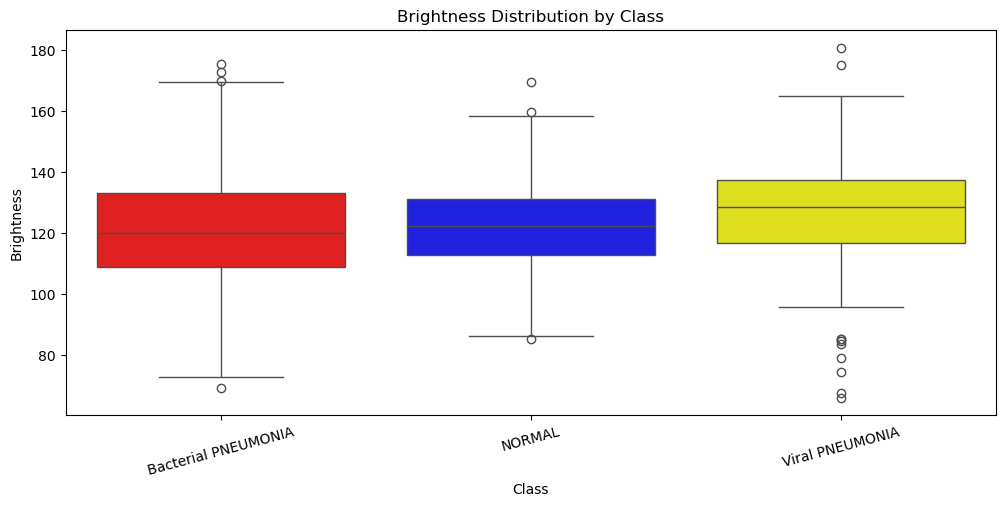

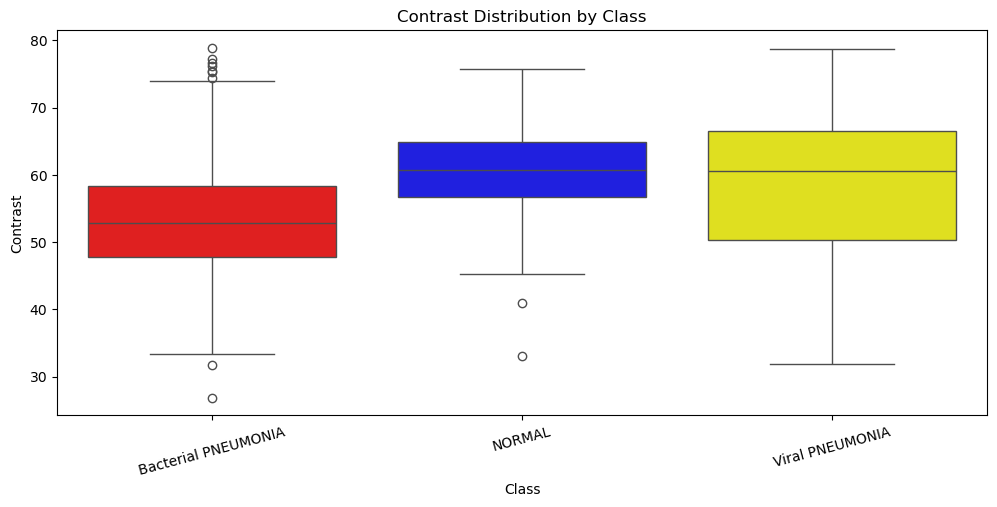

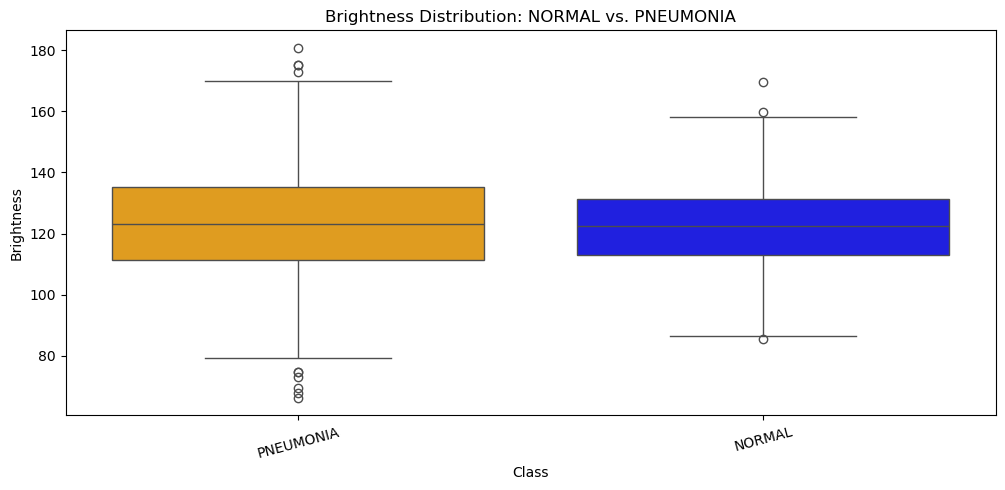

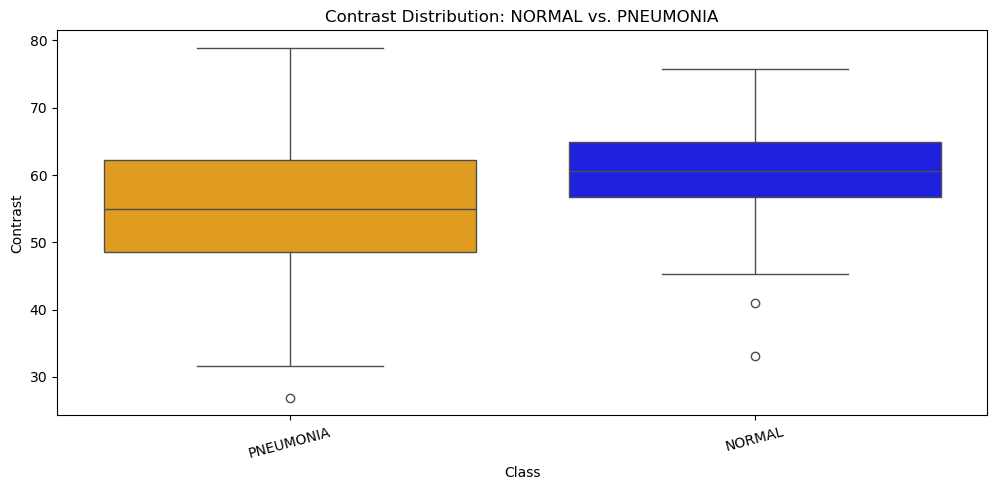

In [87]:
def analyze_brightness_contrast_by_class(df, num_samples=300):
    brightness_values = []
    contrast_values = []
    labels = []
    pneumonia_labels = []  # For grouped PNEUMONIA vs. NORMAL plots

    for img_path, label in df[['image_path', 'label']].sample(num_samples, random_state=42).values:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness = np.mean(img)  # Average pixel intensity
            contrast = np.std(img)  # Standard deviation of pixel intensities
            brightness_values.append(brightness)
            contrast_values.append(contrast)

            # Extract pneumonia subtype from the image path
            if 'virus' in img_path.lower():
                labels.append('Viral PNEUMONIA')
                pneumonia_labels.append('PNEUMONIA')
            elif 'bacteria' in img_path.lower():
                labels.append('Bacterial PNEUMONIA')
                pneumonia_labels.append('PNEUMONIA')
            else:
                labels.append('NORMAL')
                pneumonia_labels.append('NORMAL')

    # Convert to DataFrame
    brightness_df = pd.DataFrame({
        'Brightness': brightness_values, 
        'Contrast': contrast_values, 
        'Label': labels,
        'Grouped_Label': pneumonia_labels  # Just NORMAL vs. PNEUMONIA
    })

    # Define color palettes
    detailed_palette = {"NORMAL": "blue", "Bacterial PNEUMONIA": "red", "Viral PNEUMONIA": "yellow"}
    grouped_palette = {"NORMAL": "blue", "PNEUMONIA": "orange"}

    # --- Plot 1: Brightness (NORMAL vs. Bacterial vs. Viral PNEUMONIA) ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Label', y='Brightness', data=brightness_df, hue='Label', palette=detailed_palette, legend=False)
    plt.title("Brightness Distribution by Class")
    plt.xlabel("Class")
    plt.ylabel("Brightness")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/brightness_by_all_classes.png')
    plt.show()

    # --- Plot 2: Contrast (NORMAL vs. Bacterial vs. Viral PNEUMONIA) ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Label', y='Contrast', data=brightness_df, hue='Label', palette=detailed_palette, legend=False)
    plt.title("Contrast Distribution by Class")
    plt.xlabel("Class")
    plt.ylabel("Contrast")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/contrast_by_all_classes.png')
    plt.show()

    # --- Plot 3: Brightness (NORMAL vs. PNEUMONIA combined) ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Grouped_Label', y='Brightness', data=brightness_df, hue='Grouped_Label', palette=grouped_palette, legend=False)
    plt.title("Brightness Distribution: NORMAL vs. PNEUMONIA")
    plt.xlabel("Class")
    plt.ylabel("Brightness")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/brightness_by_main_classes.png')
    plt.show()

    # --- Plot 4: Contrast (NORMAL vs. PNEUMONIA combined) ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Grouped_Label', y='Contrast', data=brightness_df, hue='Grouped_Label', palette=grouped_palette, legend=False)
    plt.title("Contrast Distribution: NORMAL vs. PNEUMONIA")
    plt.xlabel("Class")
    plt.ylabel("Contrast")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/contrast_by_main_classes.png')
    plt.show()

# Run function
analyze_brightness_contrast_by_class(full_dataset_df, num_samples=math.ceil(full_dataset_df.shape[0]*0.10))

**Brightness**

- NORMAL images tend to have higher median brightness than Bacterial PNEUMONIA but are more comparable to Viral PNEUMONIA.
- Viral PNEUMONIA appears to have more variability in brightness than the other classes, possibly due to different infection patterns affecting X-ray exposure.
  
**Contrast**

- NORMAL images show slightly higher contrast on average compared to Bacterial PNEUMONIA, but Viral PNEUMONIA has the most variation.
- The NORMAL vs. PNEUMONIA (grouped) plot shows a clear shift in contrast values, reinforcing the idea that contrast might be an important distinguishing feature.

#### 3.2.2: Distribution of Pixel Intensity by Image

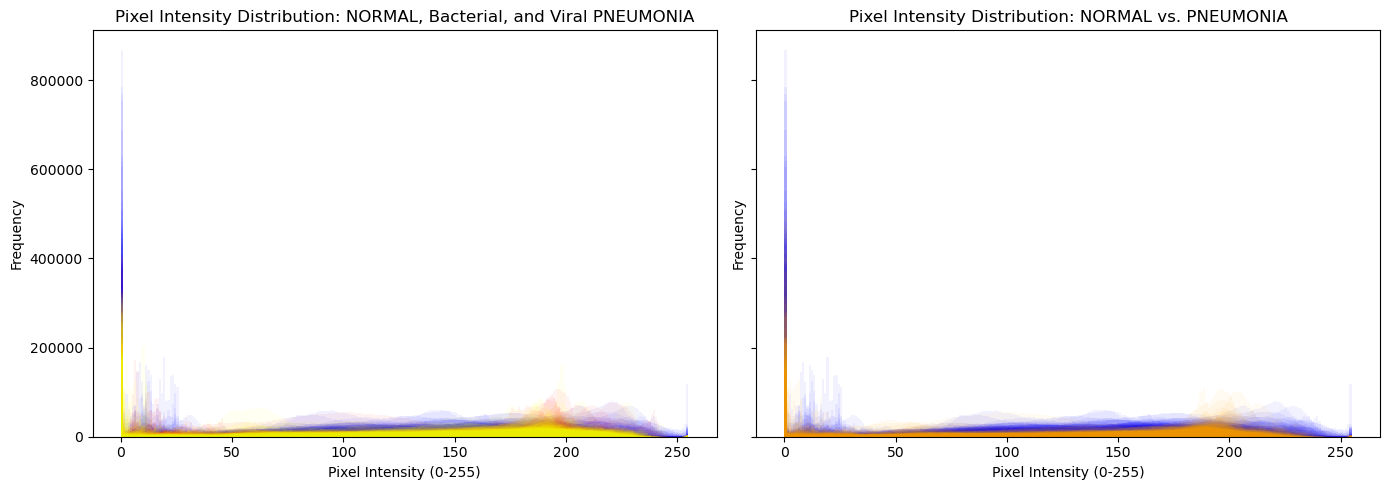

In [89]:
def compare_pixel_intensity_by_class(df, num_samples=200):
    labels = ["NORMAL", "Bacterial PNEUMONIA", "Viral PNEUMONIA"]
    grouped_labels = ["NORMAL", "PNEUMONIA"]
    colors = {"NORMAL": "blue", "Bacterial PNEUMONIA": "red", "Viral PNEUMONIA": "yellow", "PNEUMONIA": "orange"}

    # Create two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

    # --- Plot 1: NORMAL vs. Bacterial vs. Viral PNEUMONIA ---
    plt.sca(axes[0])  # Set current axis
    for label in labels:
        subset = df[df['label'] == "PNEUMONIA"]
        if label == "Bacterial PNEUMONIA":
            subset = subset[subset['image_path'].str.contains('bacteria', case=False)]
        elif label == "Viral PNEUMONIA":
            subset = subset[subset['image_path'].str.contains('virus', case=False)]
        else:
            subset = df[df['label'] == "NORMAL"]

        for img_path in subset['image_path'].sample(num_samples, random_state=42):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                plt.hist(img.ravel(), bins=256, alpha=0.05, color=colors[label])

    plt.title("Pixel Intensity Distribution: NORMAL, Bacterial, and Viral PNEUMONIA")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")

    # --- Plot 2: NORMAL vs. PNEUMONIA (Grouped) ---
    plt.sca(axes[1])  # Switch to second axis
    for label in grouped_labels:
        subset = df[df['label'] == label] if label == "NORMAL" else df[df['label'] == "PNEUMONIA"]
        
        for img_path in subset['image_path'].sample(num_samples, random_state=42):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                plt.hist(img.ravel(), bins=256, alpha=0.05, color=colors[label])

    plt.title("Pixel Intensity Distribution: NORMAL vs. PNEUMONIA")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.savefig('images/pixel_intensity_distribution_within_image_by_class.png')
    plt.show()

# Run function
compare_pixel_intensity_by_class(full_dataset_df, num_samples=math.ceil(full_dataset_df.shape[0]*0.10))

**Sharp Peak at Low Intensities (Near 0)**

- Most images have a high concentration of dark pixels.
- This is expected due to the nature of X-rays, where the background and lungs tend to appear dark while denser areas (bones, infection regions) appear brighter.
  
**Differences in Bright Pixel Distributions (Right Side of Plot)**
  
- The pneumonia cases (especially bacterial) appear to have larger varation in brighter pixels.
- This could be due to lung opacities caused by infection, making pneumonia-affected regions brighter than normal lungs.
  
**Grouped NORMAL vs. PNEUMONIA (Right Plot) Shows Similar Trends**
  
- PNEUMONIA has a wider distribution in the mid-to-high intensity range, reinforcing that infected lungs have more variable brightness patterns.
- NORMAL images appear to have a slightly tighter distribution, potentially indicating more consistent lung transparency.

#### 3.2.3: GLCM by Class

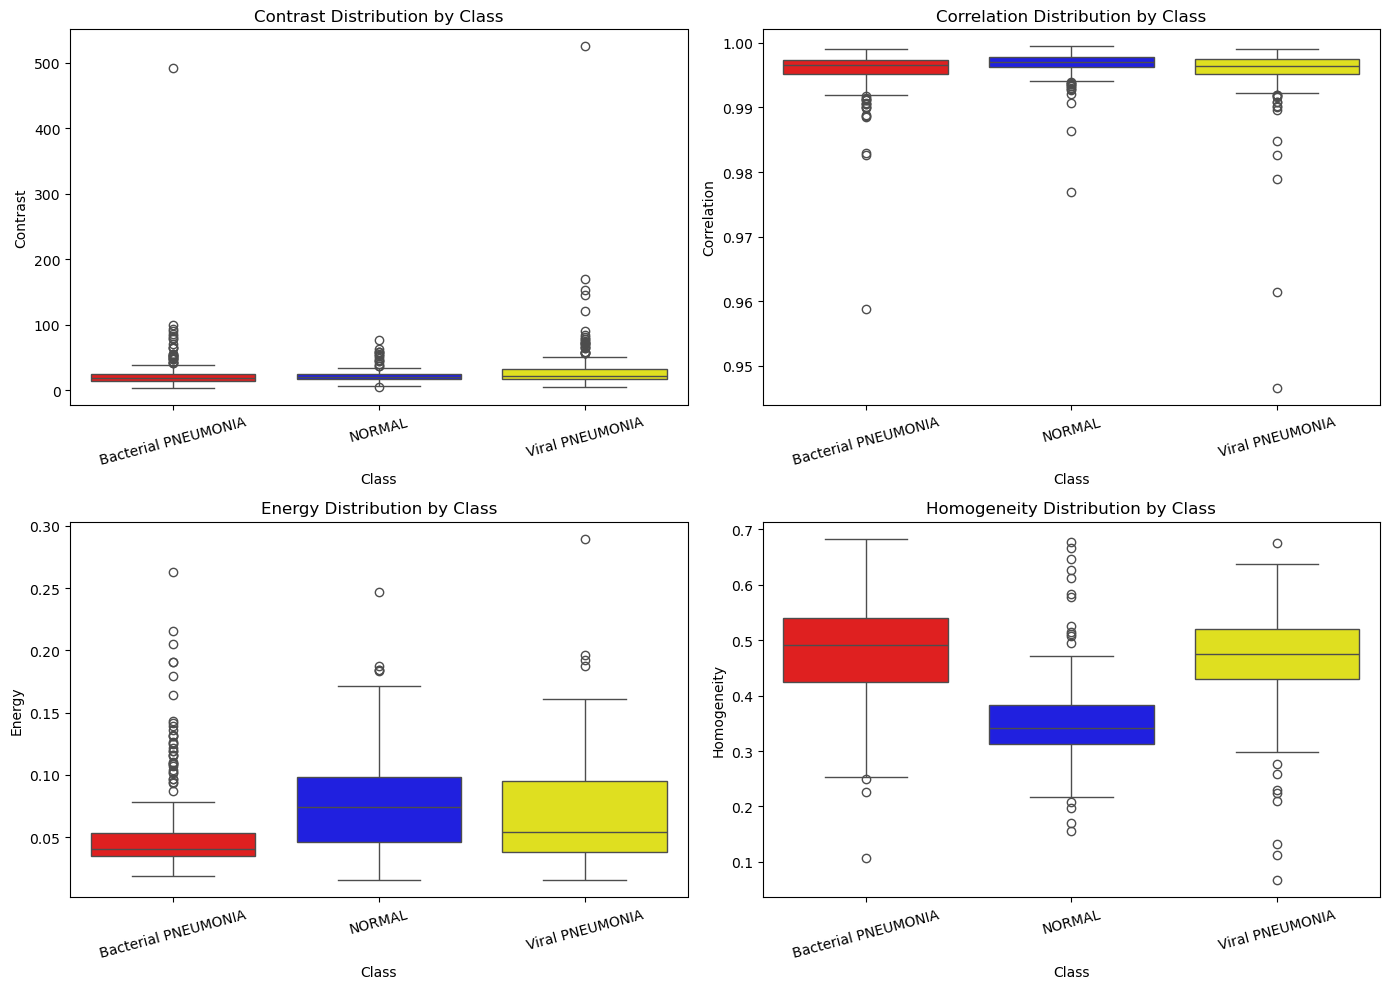

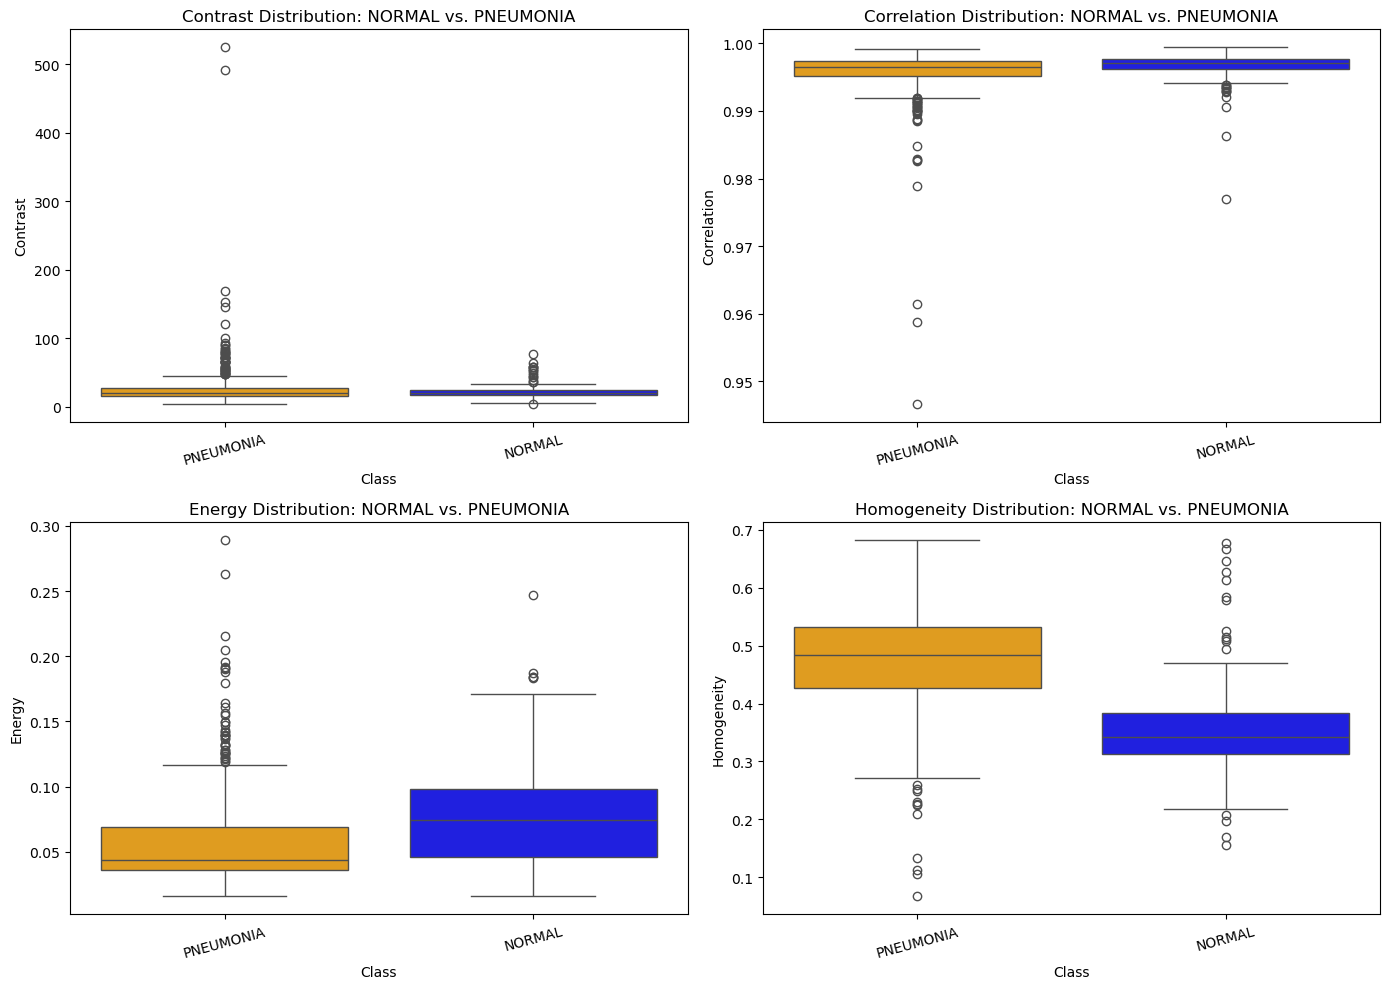

In [91]:
def compute_glcm_features(df, num_samples=300):
    
    contrast_vals, correlation_vals, energy_vals, homogeneity_vals = [], [], [], []
    labels, grouped_labels = [], []

    for img_path, label in df[['image_path', 'label']].sample(num_samples, random_state=42).values:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]
            energy = graycoprops(glcm, 'energy')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

            contrast_vals.append(contrast)
            correlation_vals.append(correlation)
            energy_vals.append(energy)
            homogeneity_vals.append(homogeneity)

            # Extract pneumonia subtype from image path
            if 'virus' in img_path.lower():
                labels.append('Viral PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            elif 'bacteria' in img_path.lower():
                labels.append('Bacterial PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            else:
                labels.append('NORMAL')
                grouped_labels.append('NORMAL')

    # Convert to DataFrame
    glcm_df = pd.DataFrame({
        'Contrast': contrast_vals, 
        'Correlation': correlation_vals, 
        'Energy': energy_vals, 
        'Homogeneity': homogeneity_vals, 
        'Label': labels,
        'Grouped_Label': grouped_labels  # For NORMAL vs. PNEUMONIA (Grouped)
    })

    # Define color palettes
    detailed_palette = {"NORMAL": "blue", "Bacterial PNEUMONIA": "red", "Viral PNEUMONIA": "yellow"}
    grouped_palette = {"NORMAL": "blue", "PNEUMONIA": "orange"}

    # GLCM Feature Names
    features = ['Contrast', 'Correlation', 'Energy', 'Homogeneity']
    
    # --- Plot 1: NORMAL vs. Bacterial vs. Viral PNEUMONIA ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for i, feature in enumerate(features):
        plt.sca(axes[i // 2, i % 2])  # Set current axis
        sns.boxplot(x='Label', y=feature, data=glcm_df, hue='Label', palette=detailed_palette, legend=False)
        plt.title(f"{feature} Distribution by Class")
        plt.xlabel("Class")
        plt.ylabel(feature)
        plt.xticks(rotation=15)

    plt.tight_layout()
    plt.savefig('images/GLMC_values_by_all_classes.png')
    plt.show()

    # --- Plot 2: NORMAL vs. PNEUMONIA (Grouped) ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for i, feature in enumerate(features):
        plt.sca(axes[i // 2, i % 2])  # Set current axis
        sns.boxplot(x='Grouped_Label', y=feature, data=glcm_df, hue='Grouped_Label', palette=grouped_palette, legend=False)
        plt.title(f"{feature} Distribution: NORMAL vs. PNEUMONIA")
        plt.xlabel("Class")
        plt.ylabel(feature)
        plt.xticks(rotation=15)

    plt.tight_layout()
    plt.savefig('images/GLCM_values_by_main_classes.png')
    plt.show()

# Run function
compute_glcm_features(full_dataset_df, num_samples = math.ceil(full_dataset_df.shape[0]*0.10))

**Contrast:**
- Most images have low contrast, but pneumonia cases (especially bacterial) show more extreme outliers.
- The overall distribution is highly right-skewed, meaning that some pneumonia cases may have much sharper textural variations.

**Correlation:**
- Very small differences across classes.
- NORMAL and PNEUMONIA cases have nearly identical medians, suggesting correlation may not be the most useful feature for classification.

**Energy:**
- NORMAL cases have a higher median energy, while pneumonia cases (especially bacterial) tend to have lower values.
- This aligns with expectations—higher energy values correspond to smoother textures, while pneumonia-affected lungs likely have more irregularities.

**Homogeneity:**
- PNEUMONIA cases (especially bacterial) exhibit higher homogeneity, meaning they tend to have more uniform textures compared to normal lungs.
- This could be due to fluid-filled lung regions in pneumonia creating more consistent grayscale values.

While Energy and Homogeneity offer strong contenders for features with high variable importance, it may be necessary to apply a transformation to some of these GLCM features.

#### 3.2.4: Edge Strength by Class

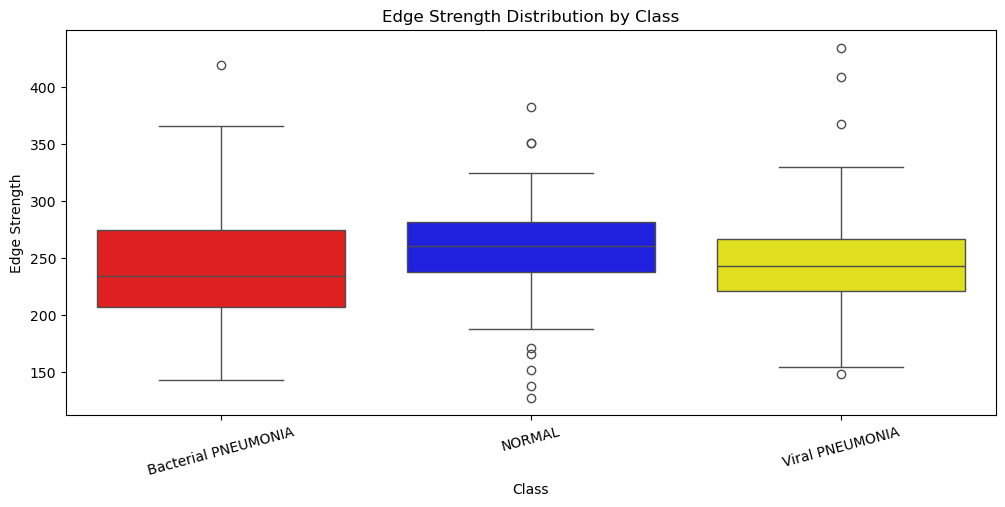

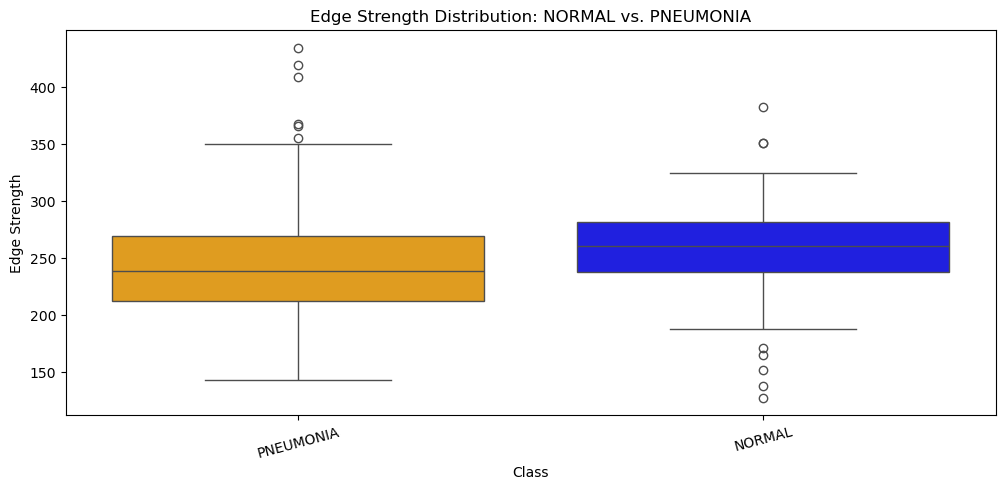

In [93]:
def compute_edge_features(df, num_samples=600):
    edge_strengths, labels, grouped_labels = [], [], []

    for img_path, label in df[['image_path', 'label']].sample(num_samples, random_state=42).values:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
            edge_magnitude = np.sqrt(sobelx**2 + sobely**2)
            edge_strengths.append(np.mean(edge_magnitude))  # Compute mean edge strength

            # Extract pneumonia subtype from image path
            if 'virus' in img_path.lower():
                labels.append('Viral PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            elif 'bacteria' in img_path.lower():
                labels.append('Bacterial PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            else:
                labels.append('NORMAL')
                grouped_labels.append('NORMAL')

    # Convert to DataFrame
    edge_df = pd.DataFrame({
        'Edge Strength': edge_strengths,
        'Label': labels,
        'Grouped_Label': grouped_labels  # For NORMAL vs. PNEUMONIA (Grouped)
    })

    # Define color palettes
    detailed_palette = {"NORMAL": "blue", "Bacterial PNEUMONIA": "red", "Viral PNEUMONIA": "yellow"}
    grouped_palette = {"NORMAL": "blue", "PNEUMONIA": "orange"}

    # --- Plot 1: NORMAL vs. Bacterial vs. Viral PNEUMONIA ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Label', y='Edge Strength', data=edge_df, hue='Label', palette=detailed_palette, legend=False)
    plt.title("Edge Strength Distribution by Class")
    plt.xlabel("Class")
    plt.ylabel("Edge Strength")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/edge_strength_all_classes.png')
    plt.show()

    # --- Plot 2: NORMAL vs. PNEUMONIA (Grouped) ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Grouped_Label', y='Edge Strength', data=edge_df, hue='Grouped_Label', palette=grouped_palette, legend=False)
    plt.title("Edge Strength Distribution: NORMAL vs. PNEUMONIA")
    plt.xlabel("Class")
    plt.ylabel("Edge Strength")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/edge_strength_main_classes.png')
    plt.show()

# Run function
compute_edge_features(full_dataset_df, num_samples=math.ceil(full_dataset_df.shape[0]*0.10))

**NORMAL vs. PNEUMONIA**

- The median edge strength is slightly higher in NORMAL cases compared to pneumonia cases.
- This could suggest that pneumonia-infected lungs may have smoother textures, potentially due to fluid buildup reducing sharp edges in X-rays.

**Bacterial vs. Viral Pneumonia**

- Viral PNEUMONIA has a more compact distribution, meaning most cases share similar edge intensity levels.
- Bacterial PNEUMONIA has a wider spread, with more extreme variations, possibly due to different infection patterns affecting lung structures differently.

#### 3.2.5: Fourier Transform Energy by Class

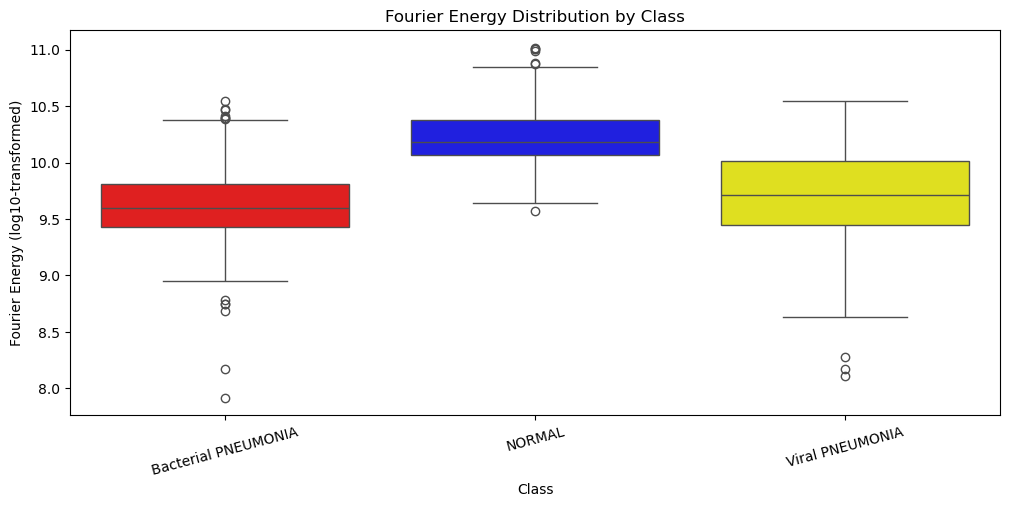

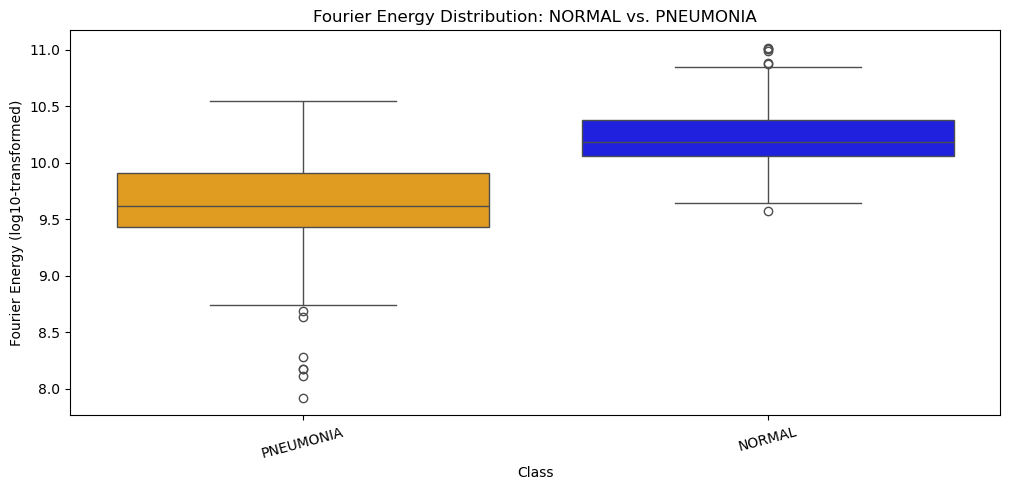

In [95]:
def compute_fourier_energy(df, num_samples=600):
    fourier_energies, labels, grouped_labels = [], [], []

    for img_path, label in df[['image_path', 'label']].sample(num_samples, random_state=42).values:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            f_transform = np.fft.fft2(img)
            f_transform_shifted = np.fft.fftshift(f_transform)
            magnitude_spectrum = np.abs(f_transform_shifted)
            fourier_energy = np.sum(magnitude_spectrum)  # Compute sum of magnitude spectrum
            fourier_energies.append(np.log10(fourier_energy + 1))  # Log10 transform to prevent issues with zero values

            # Extract pneumonia subtype from image path
            if 'virus' in img_path.lower():
                labels.append('Viral PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            elif 'bacteria' in img_path.lower():
                labels.append('Bacterial PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            else:
                labels.append('NORMAL')
                grouped_labels.append('NORMAL')

    # Convert to DataFrame
    fourier_df = pd.DataFrame({
        'Fourier Energy': fourier_energies,
        'Label': labels,
        'Grouped_Label': grouped_labels  # For NORMAL vs. PNEUMONIA (Grouped)
    })

    # Define color palettes
    detailed_palette = {"NORMAL": "blue", "Bacterial PNEUMONIA": "red", "Viral PNEUMONIA": "yellow"}
    grouped_palette = {"NORMAL": "blue", "PNEUMONIA": "orange"}

    # --- Plot 1: NORMAL vs. Bacterial vs. Viral PNEUMONIA ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Label', y='Fourier Energy', data=fourier_df, hue='Label', palette=detailed_palette, legend=False)
    plt.title("Fourier Energy Distribution by Class")
    plt.xlabel("Class")
    plt.ylabel("Fourier Energy (log10-transformed)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/log10_fourier_transform_energy_all_classes.png')
    plt.show()

    # --- Plot 2: NORMAL vs. PNEUMONIA (Grouped) ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Grouped_Label', y='Fourier Energy', data=fourier_df, hue='Grouped_Label', palette=grouped_palette, legend=False)
    plt.title("Fourier Energy Distribution: NORMAL vs. PNEUMONIA")
    plt.xlabel("Class")
    plt.ylabel("Fourier Energy (log10-transformed)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/log10_fourier_transform_energy_main_classes.png')
    plt.show()

# Run function
compute_fourier_energy(full_dataset_df, num_samples=math.ceil(full_dataset_df.shape[0]*0.10))

**NORMAL vs. PNEUMONIA**

- NORMAL cases have significantly higher Fourier energy values, indicating greater high-frequency content.
- PNEUMONIA cases (grouped) have a lower median Fourier energy, suggesting a dominance of low-frequency components, likely due to more homogeneous textures caused by lung opacities.

**Bacterial vs. Viral Pneumonia**

- Bacterial pneumonia has the lowest Fourier energy, reinforcing the idea that bacterial infections tend to create larger, smoother opacities, leading to a loss of high-frequency details.
- Viral pneumonia’s Fourier energy is higher than bacterial but still lower than NORMAL cases, which may be due to a more dispersed texture pattern in viral infections.

This looks like it could be one of our strongest features!

#### 3.2.6: Blurriness (Laplacian Variance) by Class

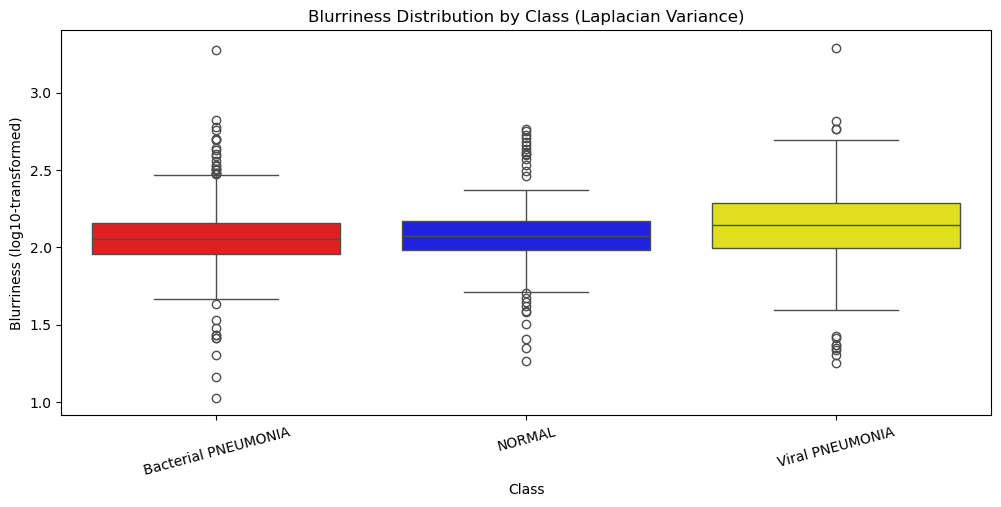

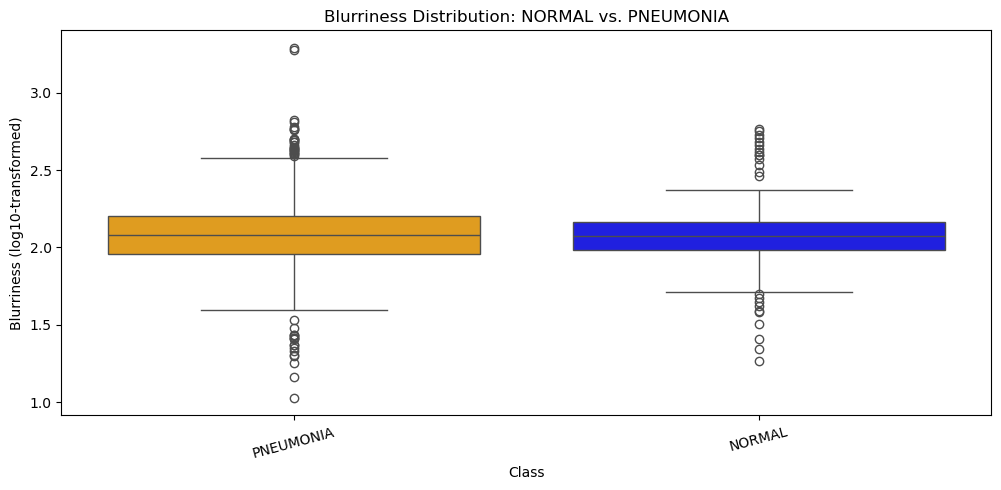

In [97]:
def compute_blurriness(df, num_samples=1000):
    blurriness_vals, labels, grouped_labels = [], [], []

    for img_path, label in df[['image_path', 'label']].sample(num_samples, random_state=42).values:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()  # Variance of Laplacian as blurriness measure
            blurriness_vals.append(np.log10(laplacian_var + 1))  # Log10 transform for visualization

            # Extract pneumonia subtype from image path
            if 'virus' in img_path.lower():
                labels.append('Viral PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            elif 'bacteria' in img_path.lower():
                labels.append('Bacterial PNEUMONIA')
                grouped_labels.append('PNEUMONIA')
            else:
                labels.append('NORMAL')
                grouped_labels.append('NORMAL')

    # Convert to DataFrame
    blur_df = pd.DataFrame({
        'Blurriness': blurriness_vals,
        'Label': labels,
        'Grouped_Label': grouped_labels  # For NORMAL vs. PNEUMONIA (Grouped)
    })

    # Define color palettes
    detailed_palette = {"NORMAL": "blue", "Bacterial PNEUMONIA": "red", "Viral PNEUMONIA": "yellow"}
    grouped_palette = {"NORMAL": "blue", "PNEUMONIA": "orange"}

    # --- Plot 1: NORMAL vs. Bacterial vs. Viral PNEUMONIA ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Label', y='Blurriness', data=blur_df, hue='Label', palette=detailed_palette, legend=False)
    plt.title("Blurriness Distribution by Class (Laplacian Variance)")
    plt.xlabel("Class")
    plt.ylabel("Blurriness (log10-transformed)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/log10_blurriness_all_classes.png')
    plt.show()

    # --- Plot 2: NORMAL vs. PNEUMONIA (Grouped) ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='Grouped_Label', y='Blurriness', data=blur_df, hue='Grouped_Label', palette=grouped_palette, legend=False)
    plt.title("Blurriness Distribution: NORMAL vs. PNEUMONIA")
    plt.xlabel("Class")
    plt.ylabel("Blurriness (log10-transformed)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('images/log10_blurriness_main_classes.png')
    plt.show()

# Run function
compute_blurriness(full_dataset_df, num_samples = math.ceil(full_dataset_df.shape[0]*0.10))

**NORMAL vs. PNEUMONIA**

- PNEUMONIA cases (grouped) tend to have slightly lower median blurriness values compared to NORMAL cases.
- This could indicate a loss of fine details in pneumonia-affected lungs, possibly due to increased lung opacity causing smoother textures.

**Bacterial vs. Viral Pneumonia**

- Viral pneumonia has a slightly higher blurriness median than bacterial pneumonia.
- This suggests that viral infections may cause more dispersed, hazy lung textures, while bacterial pneumonia might have more well-defined opacities.

This might not be the best feature alone.

### 3.3: Multivariate Analysis

In [99]:
def compute_brightness_contrast_df(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        brightness = np.mean(img)
        contrast = np.std(img)
        return brightness, contrast
    return None, None

# Apply to dataset
full_dataset_df[['Brightness', 'Contrast']] = full_dataset_df['image_path'].apply(lambda x: compute_brightness_contrast_df(x)).apply(pd.Series)

In [101]:
def compute_glcm_features_df(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return [None] * 4

    # Compute GLCM at 1-pixel offset in 0° direction
    glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return contrast, correlation, energy, homogeneity

# Apply function to dataset
full_dataset_df[['GLCM_Contrast', 'GLCM_Correlation', 'GLCM_Energy', 'GLCM_Homogeneity']] = full_dataset_df['image_path'].apply(lambda x: compute_glcm_features_df(x)).apply(pd.Series)

In [103]:
def compute_edge_strength_df(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    edge_magnitude = np.sqrt(sobelx**2 + sobely**2)

    return np.mean(edge_magnitude)

# Apply function
full_dataset_df['Edge_Strength'] = full_dataset_df['image_path'].apply(compute_edge_strength_df)

In [105]:
def compute_fourier_energy_df(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    f_transform = np.fft.fft2(img)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    
    return np.log10(np.sum(magnitude_spectrum**2) + 1)  # Log transform

# Apply function
full_dataset_df['Fourier_Energy'] = full_dataset_df['image_path'].apply(compute_fourier_energy_df)

In [107]:
def compute_blurriness_df(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    return np.log10(cv2.Laplacian(img, cv2.CV_64F).var() + 1)  # Log transform

# Apply function
full_dataset_df['Blurriness'] = full_dataset_df['image_path'].apply(compute_blurriness_df)

In [109]:
full_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_path        5824 non-null   object 
 1   label             5824 non-null   object 
 2   hash              5824 non-null   object 
 3   disease_type      5824 non-null   object 
 4   Brightness        5824 non-null   float64
 5   Contrast          5824 non-null   float64
 6   GLCM_Contrast     5824 non-null   float64
 7   GLCM_Correlation  5824 non-null   float64
 8   GLCM_Energy       5824 non-null   float64
 9   GLCM_Homogeneity  5824 non-null   float64
 10  Edge_Strength     5824 non-null   float64
 11  Fourier_Energy    5824 non-null   float64
 12  Blurriness        5824 non-null   float64
dtypes: float64(9), object(4)
memory usage: 591.6+ KB


In [111]:
full_dataset_df.head()

image_path   label  \
0  chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  NORMAL   
1  chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  NORMAL   
2          chest_xray/train/NORMAL/IM-0427-0001.jpeg  NORMAL   
3  chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  NORMAL   
4     chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg  NORMAL   

                               hash disease_type  Brightness   Contrast  \
0  37d9c9eae7fc6a4356149e071e886a52       NORMAL  124.391030  56.330762   
1  5492ab6358ac859e0090e2fce26e5804       NORMAL  115.710751  56.844688   
2  dee0187150d3ad976e0c9af6dcee3cf3       NORMAL  133.991183  65.503709   
3  c38677052671989827c12a98f4bd1b1d       NORMAL  111.488999  68.965235   
4  08eaa62c1628c0c1aaea38616c338041       NORMAL  148.148118  60.029570   

   GLCM_Contrast  GLCM_Correlation  GLCM_Energy  GLCM_Homogeneity  \
0      72.311711          0.988587     0.020208          0.186281   
1      18.847689          0.997077     0.081340          0.369210   
2      17.790796          0.997924     0.083593          0.368610   
3      18.185661          0.998087     0.142800          0.396954   
4      17.674789          0.997543     0.053182          0.321715   

   Edge_Strength  Fourier_Energy  Blurriness  
0     359.797049       17.714214    2.771691  
1     239.319756       16.582767    2.020031  
2     240.476092       17.136332    2.005923  
3     242.253012       17.120677    1.999366  
4     231.020273       17.677055    2.073492

In [ ]:
# full_dataset_df.to_csv("xray_dataset_with_features.csv", index=False)

In [113]:
size_df['Width'].median()

1280.0

In [115]:
size_df['Height'].median()

886.0

In [117]:
# Define function to extract pixel values
def extract_pixel_data(image_path, img_size=(512, 384)):  # Resize to 512x384 for consistency
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    if img is None:
        return None  # Handle missing files
    
    img_resized = cv2.resize(img, img_size)  # Resize to fixed dimensions
    return img_resized.flatten()  # Flatten into a 1D array

# Apply function to all images
pixel_data = full_dataset_df['image_path'].apply(extract_pixel_data)

# Remove any images that failed to load
pixel_data = pixel_data.dropna().apply(pd.Series)

# Rename columns
pixel_data.columns = [f'pixel_{i}' for i in range(pixel_data.shape[1])]

# Merge with the existing dataset (without non-numeric columns)
full_dataset_numeric = pd.concat([full_dataset_df.reset_index(drop=True), pixel_data.reset_index(drop=True)], axis=1)

In [119]:
full_dataset_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Columns: 196621 entries, image_path to pixel_196607
dtypes: float64(9), object(4), uint8(196608)
memory usage: 1.1+ GB


In [121]:
full_dataset_numeric.head()

image_path   label  \
0  chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  NORMAL   
1  chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  NORMAL   
2          chest_xray/train/NORMAL/IM-0427-0001.jpeg  NORMAL   
3  chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  NORMAL   
4     chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg  NORMAL   

                               hash disease_type  Brightness   Contrast  \
0  37d9c9eae7fc6a4356149e071e886a52       NORMAL  124.391030  56.330762   
1  5492ab6358ac859e0090e2fce26e5804       NORMAL  115.710751  56.844688   
2  dee0187150d3ad976e0c9af6dcee3cf3       NORMAL  133.991183  65.503709   
3  c38677052671989827c12a98f4bd1b1d       NORMAL  111.488999  68.965235   
4  08eaa62c1628c0c1aaea38616c338041       NORMAL  148.148118  60.029570   

   GLCM_Contrast  GLCM_Correlation  GLCM_Energy  GLCM_Homogeneity  ...  \
0      72.311711          0.988587     0.020208          0.186281  ...   
1      18.847689          0.997077     0.081340          0.369210  ...   
2      17.790796          0.997924     0.083593          0.368610  ...   
3      18.185661          0.998087     0.142800          0.396954  ...   
4      17.674789          0.997543     0.053182          0.321715  ...   

   pixel_196598  pixel_196599  pixel_196600  pixel_196601  pixel_196602  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   pixel_196603  pixel_196604  pixel_196605  pixel_196606  pixel_196607  
0             0             0             0             0             0  
1             0             0             0             0             0  
2             0             0             0             0             0  
3             0             0             0             0             0  
4             0             0             0             0             0  

[5 rows x 196621 columns]

In [ ]:
# Save the new dataset
# full_dataset_numeric.to_csv("dataset_with_pixels.csv", index=False)

In [123]:
# Set image_path as the index
full_dataset_numeric.set_index("image_path", inplace=True)

# Drop non-numeric columns (keeping only pixels for PCA)
pixel_columns = [col for col in full_dataset_numeric.columns if col.startswith("pixel_")]
pixel_data = full_dataset_numeric[pixel_columns]

# Check shape
print(f"Dataset contains {pixel_data.shape[0]} images and {pixel_data.shape[1]} pixel features.")

Dataset contains 5824 images and 196608 pixel features.


In [125]:
pixel_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5824 entries, chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg to chest_xray/test/PNEUMONIA/person112_bacteria_538.jpeg
Columns: 196608 entries, pixel_0 to pixel_196607
dtypes: uint8(196608)
memory usage: 1.1+ GB


In [127]:
pixel_data.head()

pixel_0  pixel_1  pixel_2  \
image_path                                                                     
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg       22       27       28   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg      121      110      100   
chest_xray/train/NORMAL/IM-0427-0001.jpeg               48       48       42   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg        0        0        2   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg         113      115      114   

                                                   pixel_3  pixel_4  pixel_5  \
image_path                                                                     
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg       27       25       29   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg       68       61       59   
chest_xray/train/NORMAL/IM-0427-0001.jpeg               49       56       59   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg        9        9       11   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg         114      114      114   

                                                   pixel_6  pixel_7  pixel_8  \
image_path                                                                     
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg       27       28       27   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg       59       57       57   
chest_xray/train/NORMAL/IM-0427-0001.jpeg               62       67       68   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg       13       16       19   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg         118      123      116   

                                                   pixel_9  ...  pixel_196598  \
image_path                                                  ...                 
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg       30  ...             0   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg       54  ...             0   
chest_xray/train/NORMAL/IM-0427-0001.jpeg               71  ...             0   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg       23  ...             0   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg         117  ...             0   

                                                   pixel_196599  pixel_196600  \
image_path                                                                      
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg             0             0   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg             0             0   
chest_xray/train/NORMAL/IM-0427-0001.jpeg                     0             0   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg             0             0   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg                0             0   

                                                   pixel_196601  pixel_196602  \
image_path                                                                      
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg             0             0   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg             0             0   
chest_xray/train/NORMAL/IM-0427-0001.jpeg                     0             0   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg             0             0   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg                0             0   

                                                   pixel_196603  pixel_196604  \
image_path                                                                      
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg             0             0   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg             0             0   
chest_xray/train/NORMAL/IM-0427-0001.jpeg                     0             0   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg             0             0   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg                0             0   

                                                   pixel_196605  pixel_196606  \
image_path     

In [129]:
# Standardizing the pixel features
scaler = StandardScaler()
pixel_data_scaled = scaler.fit_transform(pixel_data)

In [131]:
pixel_data_scaled

array([[-0.49311982, -0.41941136, -0.40293555, ..., -0.53145719,
        -0.51320559, -0.51545   ],
       [ 1.32207389,  1.09184888,  0.924611  , ..., -0.53145719,
        -0.51320559, -0.51545   ],
       [-0.01640228, -0.03704431, -0.1448015 , ..., -0.53145719,
        -0.51320559, -0.51545   ],
       ...,
       [ 3.35729108,  3.16755572,  3.04499785, ..., -0.03637789,
        -0.08205193, -0.10400757],
       [ 1.90880317,  2.4938614 ,  2.69467307, ...,  0.16747829,
         0.09548193,  0.0654099 ],
       [-0.54812569, -0.565075  , -0.56887887, ...,  0.28396754,
         0.17156787,  0.13801739]])

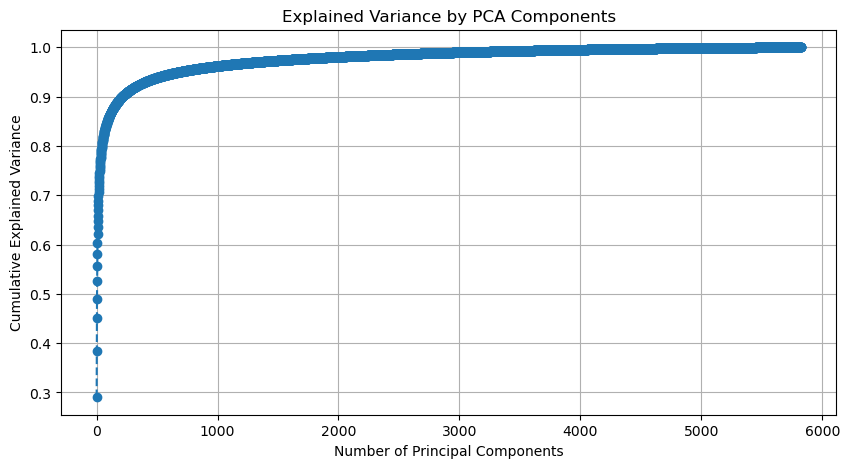

In [133]:
# Fit PCA
pca = PCA(n_components=min(pixel_data_scaled.shape))  # Keep max possible components
pixel_pca = pca.fit_transform(pixel_data_scaled)

# Compute explained variance
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid()
plt.tight_layout()
plt.savefig('images/optimal_number_of_PCA_components.png')
plt.show()

In [135]:
num_components_95 = (explained_variance_ratio >= 0.95).argmax() + 1  # Find first index where variance ≥ 95%
print(f"Number of PCA components needed for 95% variance: {num_components_95}")

Number of PCA components needed for 95% variance: 688


## 4: Data Preprocessing

In [137]:
# Function to classify dataset type based on image path
def get_data_split(image_path):
    if "train" in image_path:
        return "train"
    elif "test" in image_path:
        return "test"
    elif "val" in image_path or "valid" in image_path:
        return "validation"
    else:
        return "unknown"

# Apply function to create a new column
full_dataset_numeric["data_split"] = full_dataset_numeric.index.map(get_data_split)

# Check the distribution of splits
print(full_dataset_numeric["data_split"].value_counts())

data_split
train         5190
test           618
validation      16
Name: count, dtype: int64


In [139]:
# Split into different datasets
train_df = full_dataset_numeric[full_dataset_numeric["data_split"] == "train"].drop(columns=["data_split"])
test_df = full_dataset_numeric[full_dataset_numeric["data_split"] == "test"].drop(columns=["data_split"])
val_df = full_dataset_numeric[full_dataset_numeric["data_split"] == "validation"].drop(columns=["data_split"])

# Print sizes
print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")
print(f"Validation set: {val_df.shape}")

Train set: (5190, 196620)
Test set: (618, 196620)
Validation set: (16, 196620)


In [141]:
train_df.to_csv("train_dataset_with_features.csv")
test_df.to_csv("test_dataset_with_features.csv")
val_df.to_csv("val_dataset_with_features.csv")

In [143]:
train_df.head()

label  \
image_path                                                  
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  NORMAL   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  NORMAL   
chest_xray/train/NORMAL/IM-0427-0001.jpeg          NORMAL   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  NORMAL   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg     NORMAL   

                                                                               hash  \
image_path                                                                            
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  37d9c9eae7fc6a4356149e071e886a52   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  5492ab6358ac859e0090e2fce26e5804   
chest_xray/train/NORMAL/IM-0427-0001.jpeg          dee0187150d3ad976e0c9af6dcee3cf3   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  c38677052671989827c12a98f4bd1b1d   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg     08eaa62c1628c0c1aaea38616c338041   

                                                  disease_type  Brightness  \
image_path                                                                   
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg       NORMAL  124.391030   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg       NORMAL  115.710751   
chest_xray/train/NORMAL/IM-0427-0001.jpeg               NORMAL  133.991183   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg       NORMAL  111.488999   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg          NORMAL  148.148118   

                                                    Contrast  GLCM_Contrast  \
image_path                                                                    
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  56.330762      72.311711   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  56.844688      18.847689   
chest_xray/train/NORMAL/IM-0427-0001.jpeg          65.503709      17.790796   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  68.965235      18.185661   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg     60.029570      17.674789   

                                                   GLCM_Correlation  \
image_path                                                            
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg          0.988587   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg          0.997077   
chest_xray/train/NORMAL/IM-0427-0001.jpeg                  0.997924   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg          0.998087   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg             0.997543   

                                                   GLCM_Energy  \
image_path                                                       
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg     0.020208   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg     0.081340   
chest_xray/train/NORMAL/IM-0427-0001.jpeg             0.083593   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg     0.142800   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg        0.053182   

                                                   GLCM_Homogeneity  \
image_path                                                            
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg          0.186281   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg          0.369210   
chest_xray/train/NORMAL/IM-0427-0001.jpeg                  0.368610   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg          0.396954   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg             0.321715   

                                                   Edge_Strength  ...  \
image_path                                                        ...   
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg     359.797049  ...   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg     239.319756  ...   
chest_xray/train/NORMAL/IM-0427-0001.jpeg             240.476092  ...   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg     242.253012  ...   
chest_xray/train

In [145]:
# Standardize pixel data
scaler = StandardScaler()
train_pixels_scaled = scaler.fit_transform(train_df[pixel_columns])

# Apply PCA with 688 components
pca = PCA(n_components=688)
train_pixels_pca = pca.fit_transform(train_pixels_scaled)

# Convert to DataFrame
train_pca_df = pd.DataFrame(train_pixels_pca, index=train_df.index, columns=[f"PC{i+1}" for i in range(688)])

# Check shape
print(f"PCA-transformed train set shape: {train_pca_df.shape}")

PCA-transformed train set shape: (5190, 688)


In [147]:
# Standardize test and validation sets using the same scaler
test_pixels_scaled = scaler.transform(test_df[pixel_columns])
val_pixels_scaled = scaler.transform(val_df[pixel_columns])

# Transform with PCA (no refitting)
test_pixels_pca = pca.transform(test_pixels_scaled)
val_pixels_pca = pca.transform(val_pixels_scaled)

# Convert to DataFrames
test_pca_df = pd.DataFrame(test_pixels_pca, index=test_df.index, columns=[f"PC{i+1}" for i in range(688)])
val_pca_df = pd.DataFrame(val_pixels_pca, index=val_df.index, columns=[f"PC{i+1}" for i in range(688)])

# Check shape
print(f"PCA-transformed test set shape: {test_pca_df.shape}")
print(f"PCA-transformed validation set shape: {val_pca_df.shape}")

PCA-transformed test set shape: (618, 688)
PCA-transformed validation set shape: (16, 688)


In [149]:
# Drop original pixel columns
train_df = train_df.drop(columns=pixel_columns)
test_df = test_df.drop(columns=pixel_columns)
val_df = val_df.drop(columns=pixel_columns)

# Merge PCA-transformed features
train_final = pd.concat([train_df, train_pca_df], axis=1)
test_final = pd.concat([test_df, test_pca_df], axis=1)
val_final = pd.concat([val_df, val_pca_df], axis=1)

# Check final shapes
print(f"Final Train shape: {train_final.shape}")
print(f"Final Test shape: {test_final.shape}")
print(f"Final Validation shape: {val_final.shape}")

Final Train shape: (5190, 700)
Final Test shape: (618, 700)
Final Validation shape: (16, 700)


In [151]:
train_final

label  \
image_path                                                      
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg      NORMAL   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg      NORMAL   
chest_xray/train/NORMAL/IM-0427-0001.jpeg              NORMAL   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg      NORMAL   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg         NORMAL   
...                                                       ...   
chest_xray/train/PNEUMONIA/person142_virus_288....  PNEUMONIA   
chest_xray/train/PNEUMONIA/person364_bacteria_1...  PNEUMONIA   
chest_xray/train/PNEUMONIA/person1323_virus_228...  PNEUMONIA   
chest_xray/train/PNEUMONIA/person772_virus_1401...  PNEUMONIA   
chest_xray/train/PNEUMONIA/person501_virus_1010...  PNEUMONIA   

                                                                                hash  \
image_path                                                                             
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg   37d9c9eae7fc6a4356149e071e886a52   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg   5492ab6358ac859e0090e2fce26e5804   
chest_xray/train/NORMAL/IM-0427-0001.jpeg           dee0187150d3ad976e0c9af6dcee3cf3   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg   c38677052671989827c12a98f4bd1b1d   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg      08eaa62c1628c0c1aaea38616c338041   
...                                                                              ...   
chest_xray/train/PNEUMONIA/person142_virus_288....  3e68d0b2471c31d42ec8f05a5ab090f7   
chest_xray/train/PNEUMONIA/person364_bacteria_1...  574468e531a23c4497aac896ddb35349   
chest_xray/train/PNEUMONIA/person1323_virus_228...  494e8cc5b8daa0b054669922c6c770ff   
chest_xray/train/PNEUMONIA/person772_virus_1401...  88e30557867858a9048cff9be57bc653   
chest_xray/train/PNEUMONIA/person501_virus_1010...  7719029c8acafc54361593730f98a6f3   

                                                           disease_type  \
image_path                                                                
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg                NORMAL   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg                NORMAL   
chest_xray/train/NORMAL/IM-0427-0001.jpeg                        NORMAL   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg                NORMAL   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg                   NORMAL   
...                                                                 ...   
chest_xray/train/PNEUMONIA/person142_virus_288....      Viral Pneumonia   
chest_xray/train/PNEUMONIA/person364_bacteria_1...  Bacterial Pneumonia   
chest_xray/train/PNEUMONIA/person1323_virus_228...      Viral Pneumonia   
chest_xray/train/PNEUMONIA/person772_virus_1401...      Viral Pneumonia   
chest_xray/train/PNEUMONIA/person501_virus_1010...      Viral Pneumonia   

                                                    Brightness   Contrast  \
image_path                                                                  
chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg   124.391030  56.330762   
chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg   115.710751  56.844688   
chest_xray/train/NORMAL/IM-0427-0001.jpeg           133.991183  65.503709   
chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg   111.488999  68.965235   
chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg      148.148118  60.029570   
...                                                        ...        ...   
chest_xray/train/PNEUMONIA/person142_virus_288....   87.675905  65.870197   
chest_xray/train/PNEUMONIA/person364_bacteria_1...  121.073847  58.948950   
chest_xray/train/PNEUMONIA/person1323_virus_228...  115.075361  69.927821   
chest_xray/train/PNEUMONIA/person772_virus_1401...   80.255926  40.158139   
chest_xray/train/PNEUMONIA/person501_virus_1010...  119.434916  67.552076   

                                                    GLCM_Contrast  \
image_path        

In [153]:
train_final.to_csv("train_dataset_with_features_with_PCA.csv")
test_final.to_csv("test_dataset_with_features_with_PCA.csv")
val_final.to_csv("val_dataset_with_features_with_PCA.csv")

## 5: Dummy and Initial Model

In [155]:
# Define features (drop label, hash, disease_type)
drop_columns = ["label", "hash", "disease_type"]
X_train = train_final.drop(columns=drop_columns)
y_train = train_final["label"]

X_test = test_final.drop(columns=drop_columns)
y_test = test_final["label"]

X_val = val_final.drop(columns=drop_columns)
y_val = val_final["label"]

# Check data shape
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

Training set: (5190, 697), Labels: (5190,)
Test set: (618, 697), Labels: (618,)


In [157]:
# Initialize Dummy Classifier
dummy_clf = DummyClassifier()

# Train the classifier
dummy_clf.fit(X_train, y_train)

# Generate predictions
y_pred = dummy_clf.predict(X_test)

# Evaluate accuracy
print(f"Dummy Classifier Accuracy: {dummy_clf.score(X_test, y_test):.4f}")

Dummy Classifier Accuracy: 0.6262


In [159]:
test_final['label'].value_counts(normalize=True)

label
PNEUMONIA    0.626214
NORMAL       0.373786
Name: proportion, dtype: float64

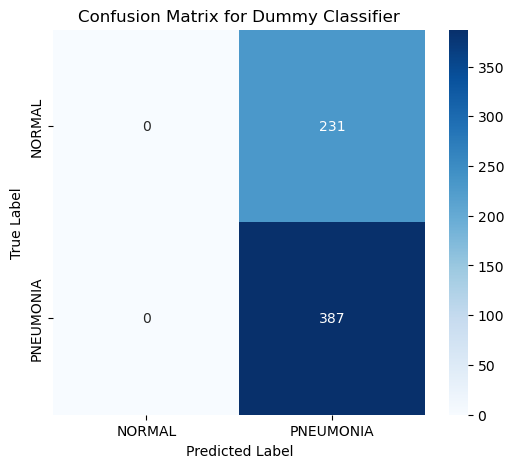

In [161]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dummy_clf.classes_, yticklabels=dummy_clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Dummy Classifier")
plt.tight_layout()
plt.savefig("images/Confusion Matrix for Dummy Classifier.png")
plt.show()

In [163]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       231
   PNEUMONIA       0.63      1.00      0.77       387

    accuracy                           0.63       618
   macro avg       0.31      0.50      0.39       618
weighted avg       0.39      0.63      0.48       618



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Dummy Classifier Accuracy, Precision, Recall, and F1-Score:

- **TP (True Positives - Pneumonia correctly identfied):** 387
- **FN (False Negatives - Pneumonia misclassified as Normal):** 0
- **TN (True Negatives - Normal correctly identified):** 0
- **FP (False Positives - Normal misclassified as Pneumonia):** 231

$\text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+FP+TN+FN}}$
$ = \frac{387+0}{387+231+0+0} = \frac{387}{618} \approx 0.6262$

$\text{Recall} =  \frac{\text{TP}}{\text{TP+FN}}$
$ = \frac{387}{387+0}=\frac{387}{387} \approx 1.0000$

$\text{Precision} = \frac{\text{TP}}{\text{TP+FP}}$
$ = \frac{387}{387+231}=\frac{387}{618} \approx 0.6262$

$\text{F1-Score} = 2 \times \frac{\text{Precision}\times \text{Recall}}{\text{Precision + Recall}}$
$ = 2 \times \frac{0.6262 \times 1.0000}{0.6262+1.0000} = 2 \times \frac{0.6262}{1.6262} \approx 0.7701$

In [165]:
# Initialize and train Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate accuracy
print(f"Random Forest Accuracy: {rf_clf.score(X_test, y_test):.4f}")

Random Forest Accuracy: 0.6893


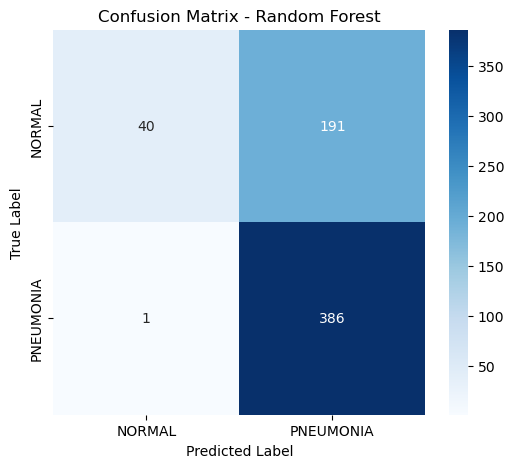

In [167]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.savefig("images/Confusion Matrix for Random Forest Classifier.png")
plt.show()

In [169]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.98      0.17      0.29       231
   PNEUMONIA       0.67      1.00      0.80       387

    accuracy                           0.69       618
   macro avg       0.82      0.59      0.55       618
weighted avg       0.78      0.69      0.61       618



Base Random Forest Accuracy, Precision, Recall, and F1-Score:

- **TP (True Positives - Pneumonia correctly identfied):** 386
- **FN (False Negatives - Pneumonia misclassified as Normal):** 1
- **TN (True Negatives - Normal correctly identified):** 40
- **FP (False Positives - Normal misclassified as Pneumonia):** 191

$\text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+FP+TN+FN}}$
$ = \frac{386+40}{40+191+386+1} = \frac{426}{618} \approx 0.6893$

$\text{Recall} =  \frac{\text{TP}}{\text{TP+FN}}$
$ = \frac{386}{386+1}=\frac{386}{387} \approx 0.9974$

$\text{Precision} = \frac{\text{TP}}{\text{TP+FP}}$
$ = \frac{386}{386+191}=\frac{386}{577} \approx 0.6690$

$\text{F1-Score} = 2 \times \frac{\text{Precision}\times \text{Recall}}{\text{Precision + Recall}}$
$ = 2 \times \frac{0.6893 \times 0.9974}{0.6893+0.9974} = 2 \times \frac{0.6875}{1.6867} \approx 0.8152$

This means the model detects almost all pneumonia cases but generates false positives for NORMAL cases. While high recall is crucial in medical settings, improving precision is necessary to reduce unnecessary follow-ups.

## 6: Results

Our analysis highlights that pneumonia X-rays differ from normal X-rays primarily due to increased contrast, sharper edges, and structural irregularities in texture and frequency distribution. These differences provide valuable signals for classification models, whether using traditional ML techniques or deep learning-based approaches.

To validate these insights, we trained two models:

1. Dummy Classifier (Baseline Model)

- As expected, the Dummy Classifier using the “most frequent” strategy performed at ~63% accuracy, which aligns with the dataset’s class imbalance (where pneumonia cases dominate).
- This confirmed that a model predicting only the majority class would achieve this baseline accuracy without truly learning meaningful patterns.

2.	Random Forest Classifier (Initial ML Model)

- The Random Forest model outperformed the Dummy Classifier, demonstrating that engineered features + PCA-transformed pixel data contain useful information for classification.
- The confusion matrix revealed that the model was better at detecting pneumonia than normal cases, suggesting that the pneumonia-related features (contrast, edge strength, and texture) provided stronger signals.
- However, misclassifications occurred, likely due to overlapping patterns in some normal and pneumonia cases or artifacts in the X-ray images.
- Summarizing the classification report, we see that we are accuractely predicting NORMAL or PNEUMONIA 69% of the time. This is a marginal improvement above the dummy model with an accuracy of roughly 63%. The precision or the accuracy of the PNEOMONIA predictions was 67%. This means that 67% of the cases we predicted as PNEUMONIA were actually PNEUMONIA cases. This again, is only a marginal improvement above the dummy classifier which had a precision score of 63%. Finally, like the dummy classifier model, this model had 100% recall, meaning all PNEUMONIA cases were predicted correctly. In other words, there are more false positives for PNEUMONIA and 0 false negatives

## 7: Continue Work in 'Final Modeling Steps' and 'Final CNN Modeling'

The next notebook will focus on hyperparameter tuning, feature selection, and testing alternative ML models, including Support Vector Machines (SVM) and ensembles of Random Forests. Later, we will explore deep learning-based CNNs.